## LSTM model

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Embedding, Flatten
import os

import numpy as np
import tensorflow as tf
import random as python_random

def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

reset_random_seeds()

df = pd.read_csv('/content/Exports value by harmonized system.csv')

df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)
aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()
melted_df = pd.melt(aggregated_data, id_vars=['HS Section'], var_name='Month', value_name='Export_Value')
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)

train_series = total_export_values[:'2019-12-31']
test_series = total_export_values['2020-01-01':]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_series.values.reshape(-1, 1))
scaled_test = scaler.transform(test_series.values.reshape(-1, 1))

def series_to_supervised(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in), 0])
        y.append(data[i + n_in:i + n_in + n_out, 0])
    return np.array(X), np.array(y)

n_input = 1
train_X, train_y = series_to_supervised(scaled_train, n_in=n_input)
test_X, test_y = series_to_supervised(scaled_test, n_in=n_input)

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))




lstm_model = Sequential()
lstm_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')
history = lstm_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)



Epoch 1/400
2/2 - 8s - loss: 0.4839 - val_loss: 0.6644 - 8s/epoch - 4s/step
Epoch 2/400
2/2 - 0s - loss: 0.4675 - val_loss: 0.6471 - 117ms/epoch - 58ms/step
Epoch 3/400
2/2 - 0s - loss: 0.4513 - val_loss: 0.6296 - 132ms/epoch - 66ms/step
Epoch 4/400
2/2 - 0s - loss: 0.4350 - val_loss: 0.6127 - 154ms/epoch - 77ms/step
Epoch 5/400
2/2 - 0s - loss: 0.4191 - val_loss: 0.5965 - 158ms/epoch - 79ms/step
Epoch 6/400
2/2 - 0s - loss: 0.4027 - val_loss: 0.5801 - 137ms/epoch - 69ms/step
Epoch 7/400
2/2 - 0s - loss: 0.3865 - val_loss: 0.5634 - 76ms/epoch - 38ms/step
Epoch 8/400
2/2 - 0s - loss: 0.3697 - val_loss: 0.5464 - 93ms/epoch - 47ms/step
Epoch 9/400
2/2 - 0s - loss: 0.3519 - val_loss: 0.5290 - 136ms/epoch - 68ms/step
Epoch 10/400
2/2 - 0s - loss: 0.3346 - val_loss: 0.5110 - 155ms/epoch - 77ms/step
Epoch 11/400
2/2 - 0s - loss: 0.3162 - val_loss: 0.4925 - 164ms/epoch - 82ms/step
Epoch 12/400
2/2 - 0s - loss: 0.2971 - val_loss: 0.4734 - 198ms/epoch - 99ms/step
Epoch 13/400
2/2 - 0s - loss: 0.

1/1 [==============================] - 1s 656ms/step


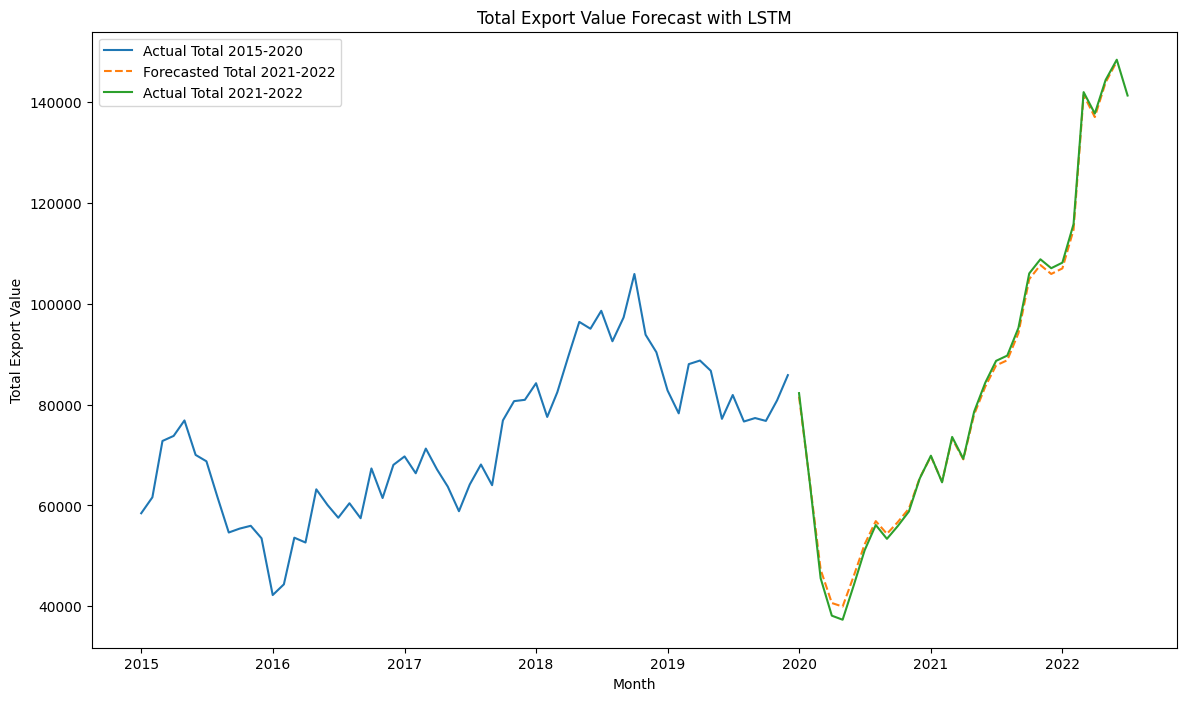

In [2]:
yhat = lstm_model.predict(test_X)


inv_yhat = scaler.inverse_transform(yhat)

plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with LSTM')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_lstm = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse_lstm)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Simple LSTM")
print(f'MSE: {mse_lstm}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')




Simple LSTM
MSE: 1180754.0779682146
RMSE: 1086.6250862041675
MAD: 892.8859942750045
MAPE: 1.4465494704393687%


In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


deep_lstm_model = Sequential()

deep_lstm_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
deep_lstm_model.add(Dropout(0.2))


deep_lstm_model.add(LSTM(100))
deep_lstm_model.add(Dropout(0.2))


deep_lstm_model.add(Dense(50, activation='relu'))

deep_lstm_model.add(Dense(1))


deep_lstm_model.compile(loss='mae', optimizer='adam')

history = deep_lstm_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)


Epoch 1/400
2/2 - 5s - loss: 0.4812 - val_loss: 0.6623 - 5s/epoch - 3s/step
Epoch 2/400
2/2 - 0s - loss: 0.4645 - val_loss: 0.6436 - 55ms/epoch - 27ms/step
Epoch 3/400
2/2 - 0s - loss: 0.4454 - val_loss: 0.6227 - 48ms/epoch - 24ms/step
Epoch 4/400
2/2 - 0s - loss: 0.4238 - val_loss: 0.6008 - 46ms/epoch - 23ms/step
Epoch 5/400
2/2 - 0s - loss: 0.4008 - val_loss: 0.5757 - 48ms/epoch - 24ms/step
Epoch 6/400
2/2 - 0s - loss: 0.3732 - val_loss: 0.5464 - 49ms/epoch - 24ms/step
Epoch 7/400
2/2 - 0s - loss: 0.3422 - val_loss: 0.5119 - 80ms/epoch - 40ms/step
Epoch 8/400
2/2 - 0s - loss: 0.3033 - val_loss: 0.4737 - 48ms/epoch - 24ms/step
Epoch 9/400
2/2 - 0s - loss: 0.2656 - val_loss: 0.4311 - 49ms/epoch - 24ms/step
Epoch 10/400
2/2 - 0s - loss: 0.2222 - val_loss: 0.3895 - 50ms/epoch - 25ms/step
Epoch 11/400
2/2 - 0s - loss: 0.1798 - val_loss: 0.3485 - 51ms/epoch - 25ms/step
Epoch 12/400
2/2 - 0s - loss: 0.1412 - val_loss: 0.3122 - 68ms/epoch - 34ms/step
Epoch 13/400
2/2 - 0s - loss: 0.1344 - va

1/1 [==============================] - 1s 831ms/step


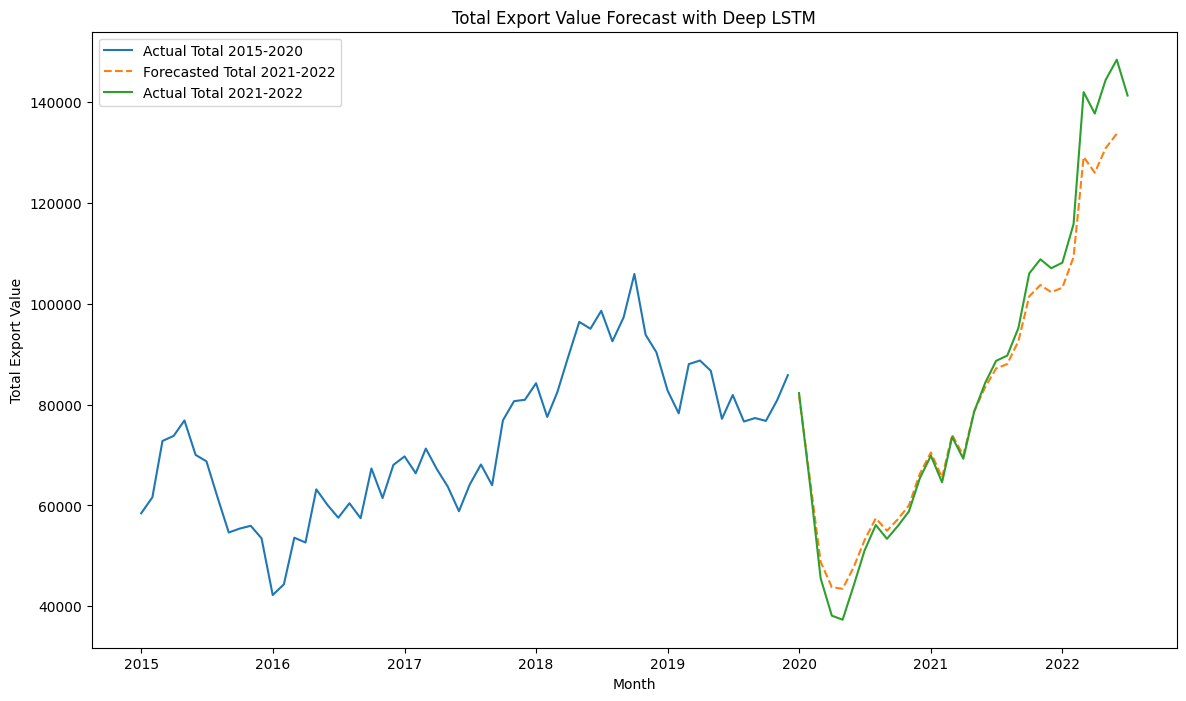

In [5]:

yhat = deep_lstm_model.predict(test_X)


inv_yhat = scaler.inverse_transform(yhat)

plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with Deep LSTM')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_deep_lstm = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse_deep_lstm)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Deep LSTM")
print(f'MSE: {mse_deep_lstm}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')




Deep LSTM
MSE: 31972707.86832825
RMSE: 5654.441428499215
MAD: 3884.0511184000034
MAPE: 4.519197630723736%


## Transfomer


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Embedding, Flatten
import os

import numpy as np
import tensorflow as tf
import random as python_random

def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'


reset_random_seeds()


df = pd.read_csv('/content/Exports value by harmonized system.csv')


df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)
aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()
melted_df = pd.melt(aggregated_data, id_vars=['HS Section'], var_name='Month', value_name='Export_Value')
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')


pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)


train_series = total_export_values[:'2019-12-31']
test_series = total_export_values['2020-01-01':]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_series.values.reshape(-1, 1))
scaled_test = scaler.transform(test_series.values.reshape(-1, 1))

def series_to_supervised(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in), 0])
        y.append(data[i + n_in:i + n_in + n_out, 0])
    return np.array(X), np.array(y)

n_input = 1
train_X, train_y = series_to_supervised(scaled_train, n_in=n_input)
test_X, test_y = series_to_supervised(scaled_test, n_in=n_input)



train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Train set
print("First 3 Training Features:")
print(train_X[:3].reshape(-1))
print("First 3 Training Labels:")
print(train_y[:3].reshape(-1))

# Test set
print("\nFirst 3 Test Features:")
print(test_X[:3].reshape(-1))
print("First 3 Test Labels:")
print(test_y[:3].reshape(-1))

# Training Set:
# First 3 Training Features: [0.376, 0.963, 0.740]
# First 3 Training Labels: [0.963, 0.740, 0.604]
# Each training label follows its corresponding feature(
    #the model's task is to predict the next value in the sequence based on the current value,
    #For instance, given the feature 0.376, the corresponding label to predict is 0.963.

# Test Set:
# First 3 Test Features: [0.874, 0.630, 0.332]
# First 3 Test Labels: [0.630, 0.332, 0.059]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs


    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

inputs = Input(shape=(n_input, 1))
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = Flatten()(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer="adam", loss="mean_squared_error")

history = transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)

First 3 Training Features:
[0.25473934 0.30448737 0.47991905]
First 3 Training Labels:
[0.30448737 0.47991905 0.49564346]

First 3 Test Features:
[0.6289496  0.33951669 0.0522013 ]
First 3 Test Labels:
[ 0.33951669  0.0522013  -0.06423759]
Epoch 1/400
2/2 - 3s - loss: 0.0458 - val_loss: 0.0723 - 3s/epoch - 1s/step
Epoch 2/400
2/2 - 0s - loss: 0.0289 - val_loss: 0.0573 - 39ms/epoch - 19ms/step
Epoch 3/400
2/2 - 0s - loss: 0.0217 - val_loss: 0.0505 - 43ms/epoch - 21ms/step
Epoch 4/400
2/2 - 0s - loss: 0.0212 - val_loss: 0.0491 - 53ms/epoch - 27ms/step
Epoch 5/400
2/2 - 0s - loss: 0.0260 - val_loss: 0.0492 - 38ms/epoch - 19ms/step
Epoch 6/400
2/2 - 0s - loss: 0.0294 - val_loss: 0.0487 - 37ms/epoch - 19ms/step
Epoch 7/400
2/2 - 0s - loss: 0.0251 - val_loss: 0.0487 - 39ms/epoch - 19ms/step
Epoch 8/400
2/2 - 0s - loss: 0.0261 - val_loss: 0.0499 - 53ms/epoch - 27ms/step
Epoch 9/400
2/2 - 0s - loss: 0.0194 - val_loss: 0.0522 - 42ms/epoch - 21ms/step
Epoch 10/400
2/2 - 0s - loss: 0.0234 - val_l

1/1 [==============================] - 0s 193ms/step


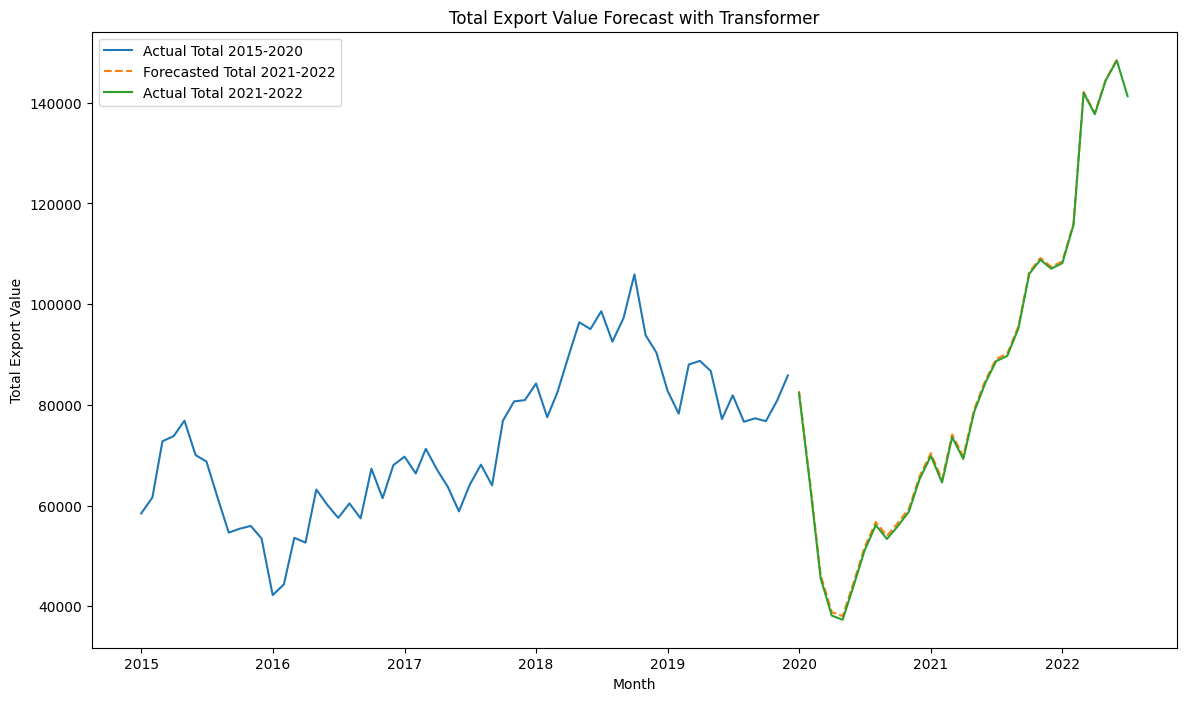

In [8]:

yhat = transformer_model.predict(test_X)


inv_yhat = scaler.inverse_transform(yhat)

plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with Transformer')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_transformer = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse_transformer)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Transfomer")
print(f'MSE: {mse_transformer}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')




Transfomer
MSE: 259862.76229357335
RMSE: 509.7673609535759
MAD: 482.92929518333113
MAPE: 0.7600862809381826%


In [10]:
# import tensorflow as tf
# import keras

# print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)


In [11]:
# !pip install TensorFlow==2.12.0
# !pip install Keras==2.12.0

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Embedding, Flatten
import os

import numpy as np
import tensorflow as tf
import random as python_random

def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'


reset_random_seeds()



df = pd.read_csv('/content/Exports value by harmonized system.csv')


df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)
aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()
melted_df = pd.melt(aggregated_data, id_vars=['HS Section'], var_name='Month', value_name='Export_Value')
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)

total_export_values.head()
train_series = total_export_values[:'2019-12-31']
test_series = total_export_values['2020-01-01':]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_series.values.reshape(-1, 1))
scaled_test = scaler.transform(test_series.values.reshape(-1, 1))


def series_to_supervised(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in), 0])
        y.append(data[i + n_in:i + n_in + n_out, 0])
    return np.array(X), np.array(y)

n_input = 1
train_X, train_y = series_to_supervised(scaled_train, n_in=n_input)
test_X, test_y = series_to_supervised(scaled_test, n_in=n_input)


train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

inputs = Input(shape=(n_input, 1))
x = transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=64, dropout=0.1)
x = Flatten()(x)
outputs = Dense(1)(x)

complex_transformer_model = Model(inputs, outputs)
complex_transformer_model.compile(optimizer="adam", loss="mean_squared_error")


history = complex_transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)

Epoch 1/400
2/2 - 3s - loss: 0.0447 - val_loss: 0.0665 - 3s/epoch - 2s/step
Epoch 2/400
2/2 - 0s - loss: 0.0251 - val_loss: 0.0521 - 37ms/epoch - 19ms/step
Epoch 3/400
2/2 - 0s - loss: 0.0214 - val_loss: 0.0495 - 38ms/epoch - 19ms/step
Epoch 4/400
2/2 - 0s - loss: 0.0240 - val_loss: 0.0498 - 37ms/epoch - 18ms/step
Epoch 5/400
2/2 - 0s - loss: 0.0285 - val_loss: 0.0491 - 44ms/epoch - 22ms/step
Epoch 6/400
2/2 - 0s - loss: 0.0281 - val_loss: 0.0493 - 42ms/epoch - 21ms/step
Epoch 7/400
2/2 - 0s - loss: 0.0223 - val_loss: 0.0517 - 40ms/epoch - 20ms/step
Epoch 8/400
2/2 - 0s - loss: 0.0238 - val_loss: 0.0553 - 38ms/epoch - 19ms/step
Epoch 9/400
2/2 - 0s - loss: 0.0207 - val_loss: 0.0576 - 37ms/epoch - 19ms/step
Epoch 10/400
2/2 - 0s - loss: 0.0250 - val_loss: 0.0574 - 39ms/epoch - 19ms/step
Epoch 11/400
2/2 - 0s - loss: 0.0239 - val_loss: 0.0558 - 58ms/epoch - 29ms/step
Epoch 12/400
2/2 - 0s - loss: 0.0194 - val_loss: 0.0525 - 39ms/epoch - 20ms/step
Epoch 13/400
2/2 - 0s - loss: 0.0222 - va

1/1 [==============================] - 0s 178ms/step


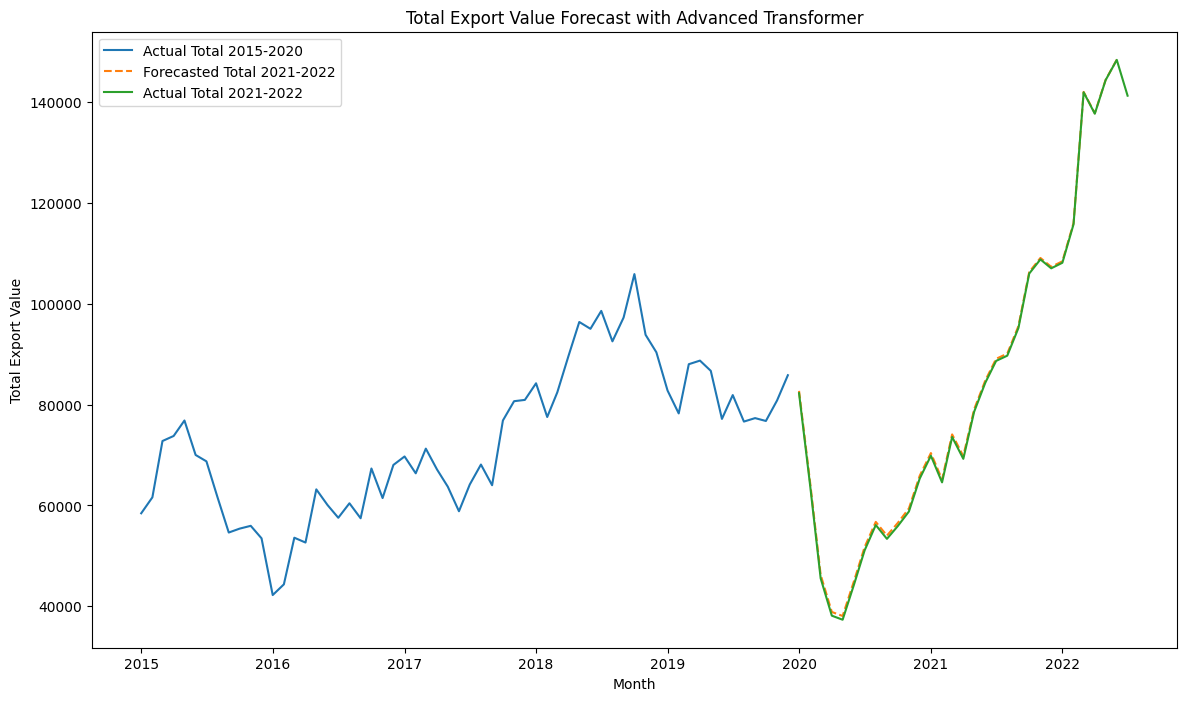

In [13]:
yhat = complex_transformer_model.predict(test_X)


inv_yhat = scaler.inverse_transform(yhat)

plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with Advanced Transformer')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_advanced_transformer = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse_advanced_transformer)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Advanced Transfomer")
print(f'MSE: {mse_advanced_transformer}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')




Advanced Transfomer
MSE: 246510.0120275449
RMSE: 496.4977462461888
MAD: 452.6627587249978
MAPE: 0.7382325300724193%


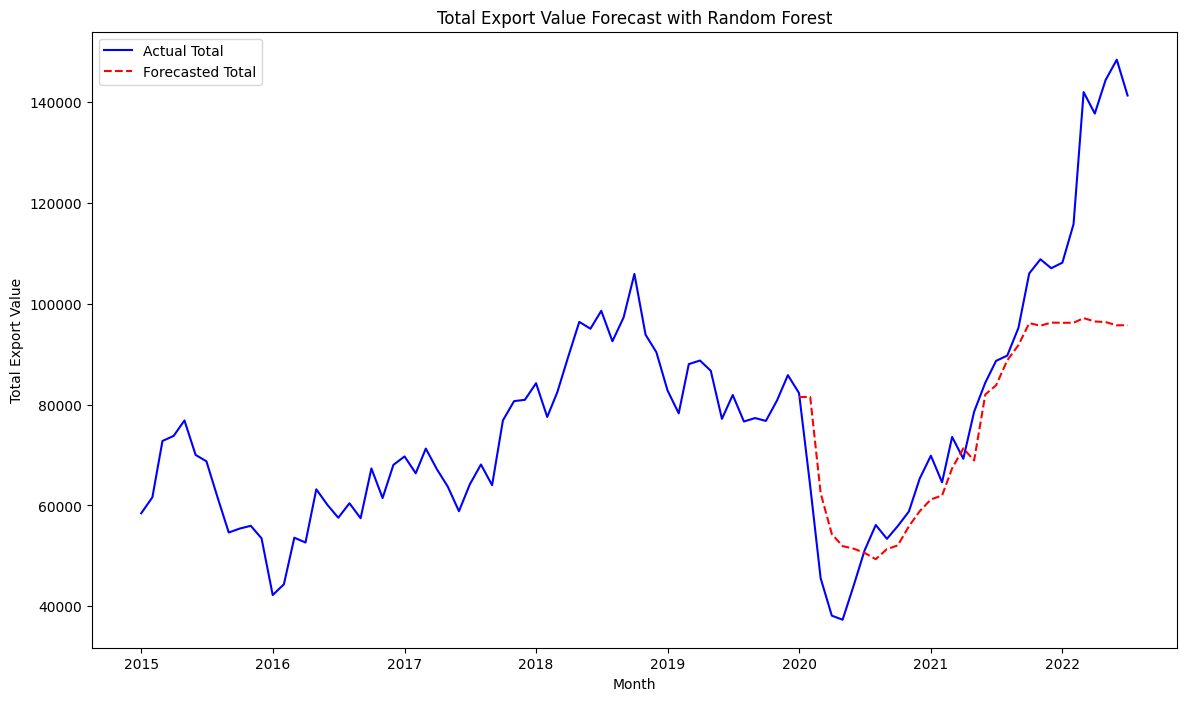

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

kf = StratifiedKFold(n_splits=10)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import pandas as pd

df = pd.read_csv('/content/Exports value by harmonized system.csv')

df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)

aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()



melted_df = pd.melt(aggregated_data, id_vars=['HS Section'],
                    value_vars=['2015 / 01', '2015 / 02', '2015 / 03', '2015 / 04', '2015 / 05','2015 / 06', '2015 / 07', '2015 / 08', '2015 / 09', '2015 / 10', '2015 / 11', '2015 / 12','2016 / 01', '2016 / 02', '2016 / 03', '2016 / 04', '2016 / 05','2016 / 06', '2016 / 07', '2016 / 08', '2016 / 09', '2016 / 10', '2016 / 11', '2016 / 12','2017 / 01', '2017 / 02', '2017 / 03', '2017 / 04', '2017 / 05','2017 / 06', '2017 / 07', '2017 / 08', '2017 / 09', '2017 / 10', '2017 / 11', '2017 / 12','2018 / 01', '2018 / 02', '2018 / 03', '2018 / 04', '2018 / 05','2018 / 06', '2018 / 07', '2018 / 08', '2018 / 09', '2018 / 10', '2018 / 11', '2018 / 12','2019 / 01', '2019 / 02', '2019 / 03', '2019 / 04', '2019 / 05','2019 / 06', '2019 / 07', '2019 / 08', '2019 / 09', '2019 / 10', '2019 / 11', '2019 / 12','2020 / 01', '2020 / 02', '2020 / 03', '2020 / 04', '2020 / 05','2020 / 06', '2020 / 07', '2020 / 08', '2020 / 09', '2020 / 10', '2020 / 11', '2020 / 12','2021 / 01', '2021 / 02', '2021 / 03', '2021 / 04', '2021 / 05','2021 / 06', '2021 / 07', '2021 / 08', '2021 / 09', '2021 / 10', '2021 / 11', '2021 / 12','2022 / 01', '2022 / 02', '2022 / 03', '2022 / 04', '2022 / 05', '2022 / 06', '2022 / 07'],
                    var_name='Month', value_name='Export_Value')
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

ohet = ohe.fit_transform(melted_df[['HS Section']])


pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)


train_df = total_export_values[:'2019-12-31']
test_df = total_export_values['2020-01-01':]



total_export_values = pivot_df.sum(axis=1)


total_export_df = pd.DataFrame(total_export_values, columns=['Total_Export_Value'])


for i in range(1, 13):
    total_export_df[f'lag_{i}'] = total_export_df['Total_Export_Value'].shift(i)


total_export_df.dropna(inplace=True)


train_df = total_export_df[:'2019-12-31']
test_df = total_export_df['2020-01-01':]

X_train = train_df.drop('Total_Export_Value', axis=1)
y_train = train_df['Total_Export_Value']
X_test = test_df.drop('Total_Export_Value', axis=1)
y_test = test_df['Total_Export_Value']


from sklearn.ensemble import RandomForestRegressor


rf_regressor = RandomForestRegressor(random_state=42, max_depth= None, min_samples_split= 2, n_estimators= 1000)


rf_regressor.fit(X_train, y_train)


plt.figure(figsize=(14, 8))


plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')


forecast_dates = test_df.index


predictions = rf_regressor.predict(X_test)


plt.plot(forecast_dates, predictions, label='Forecasted Total', linestyle='--', color='red')

plt.title('Total Export Value Forecast with Random Forest')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()










In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'actual' refers to y_test and 'forecasted' refers to predictions
actual = y_test
forecasted = predictions

# MSE
mse = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

mse, rmse, mad, mape

(428208024.1568202, 20693.187868398145, 14008.238810530613, 15.392588687673426)

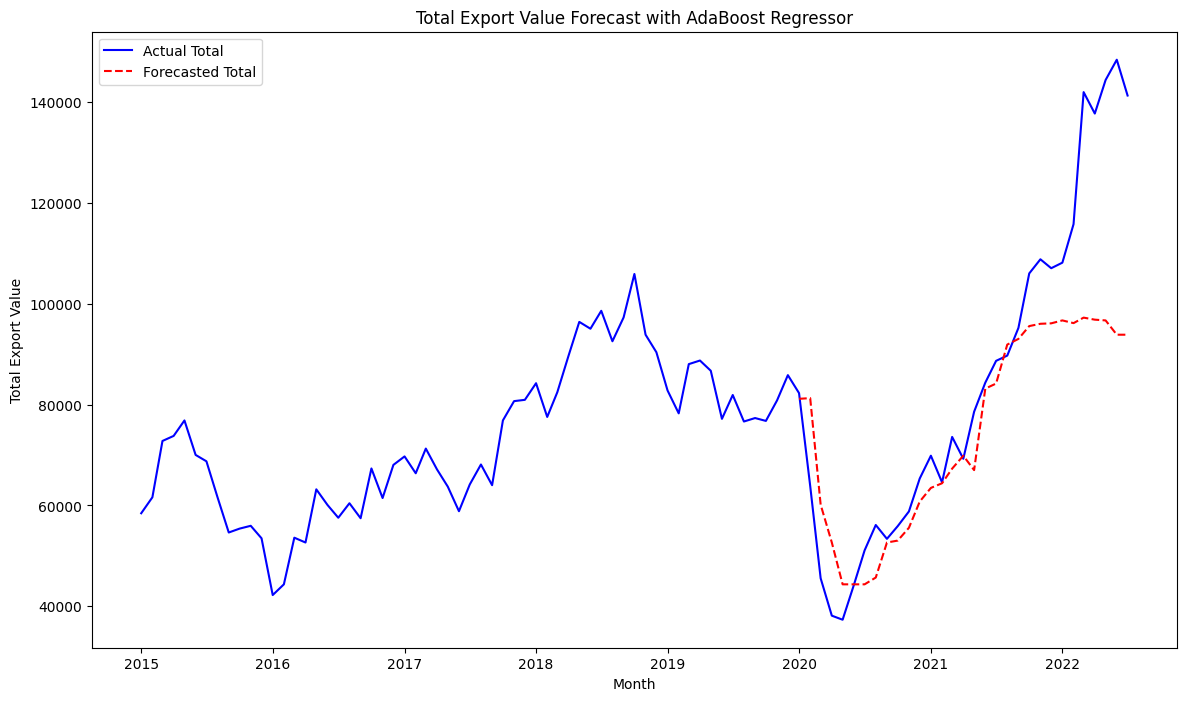

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

kf = StratifiedKFold(n_splits=10)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import pandas as pd

df = pd.read_csv('/content/Exports value by harmonized system.csv')

df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)

aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()



melted_df = pd.melt(aggregated_data, id_vars=['HS Section'],
                    value_vars=['2015 / 01', '2015 / 02', '2015 / 03', '2015 / 04', '2015 / 05','2015 / 06', '2015 / 07', '2015 / 08', '2015 / 09', '2015 / 10', '2015 / 11', '2015 / 12','2016 / 01', '2016 / 02', '2016 / 03', '2016 / 04', '2016 / 05','2016 / 06', '2016 / 07', '2016 / 08', '2016 / 09', '2016 / 10', '2016 / 11', '2016 / 12','2017 / 01', '2017 / 02', '2017 / 03', '2017 / 04', '2017 / 05','2017 / 06', '2017 / 07', '2017 / 08', '2017 / 09', '2017 / 10', '2017 / 11', '2017 / 12','2018 / 01', '2018 / 02', '2018 / 03', '2018 / 04', '2018 / 05','2018 / 06', '2018 / 07', '2018 / 08', '2018 / 09', '2018 / 10', '2018 / 11', '2018 / 12','2019 / 01', '2019 / 02', '2019 / 03', '2019 / 04', '2019 / 05','2019 / 06', '2019 / 07', '2019 / 08', '2019 / 09', '2019 / 10', '2019 / 11', '2019 / 12','2020 / 01', '2020 / 02', '2020 / 03', '2020 / 04', '2020 / 05','2020 / 06', '2020 / 07', '2020 / 08', '2020 / 09', '2020 / 10', '2020 / 11', '2020 / 12','2021 / 01', '2021 / 02', '2021 / 03', '2021 / 04', '2021 / 05','2021 / 06', '2021 / 07', '2021 / 08', '2021 / 09', '2021 / 10', '2021 / 11', '2021 / 12','2022 / 01', '2022 / 02', '2022 / 03', '2022 / 04', '2022 / 05', '2022 / 06', '2022 / 07'],
                    var_name='Month', value_name='Export_Value')
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False).set_output(transform='pandas')

ohet = ohe.fit_transform(melted_df[['HS Section']])


pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)


train_df = total_export_values[:'2019-12-31']
test_df = total_export_values['2020-01-01':]



total_export_values = pivot_df.sum(axis=1)


total_export_df = pd.DataFrame(total_export_values, columns=['Total_Export_Value'])


for i in range(1, 13):
    total_export_df[f'lag_{i}'] = total_export_df['Total_Export_Value'].shift(i)


total_export_df.dropna(inplace=True)


train_df = total_export_df[:'2019-12-31']
test_df = total_export_df['2020-01-01':]

X_train = train_df.drop('Total_Export_Value', axis=1)
y_train = train_df['Total_Export_Value']
X_test = test_df.drop('Total_Export_Value', axis=1)
y_test = test_df['Total_Export_Value']


from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


ada_regressor = AdaBoostRegressor(random_state=42, n_estimators= 1000)


ada_regressor.fit(X_train, y_train)


plt.figure(figsize=(14, 8))


plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')


forecast_dates = test_df.index


predictions = ada_regressor.predict(X_test)


plt.plot(forecast_dates, predictions, label='Forecasted Total', linestyle='--', color='red')

plt.title('Total Export Value Forecast with AdaBoost Regressor')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()










In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'actual' refers to y_test and 'forecasted' refers to predictions
actual = y_test
forecasted = predictions

# MSE
mse = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

mse, rmse, mad, mape

(428840065.89239204,
 20708.453971564173,
 13515.521415471307,
 14.107954711648283)

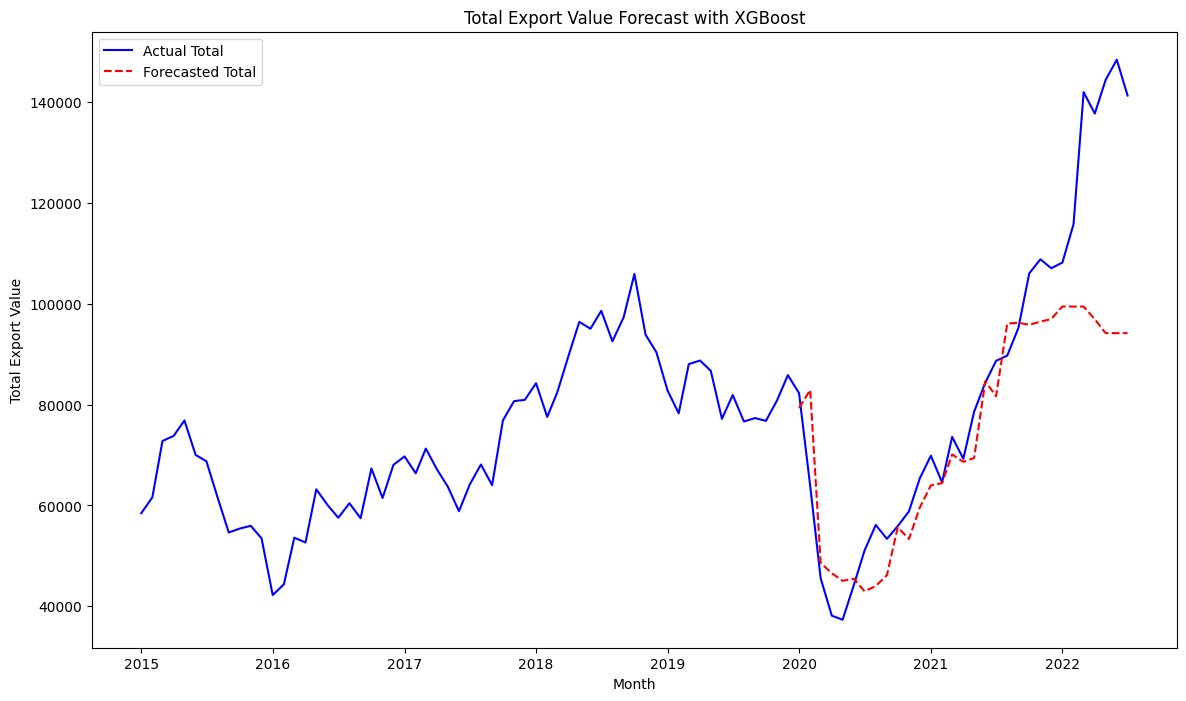

In [19]:

from xgboost import XGBRegressor


xgb_regressor = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=5)

xgb_regressor.fit(X_train, y_train)


predictions = xgb_regressor.predict(X_test)


plt.figure(figsize=(14, 8))
plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
plt.plot(forecast_dates, predictions, label='Forecasted Total', linestyle='--', color='red')

plt.title('Total Export Value Forecast with XGBoost')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'actual' refers to y_test and 'forecasted' refers to predictions
actual = y_test
forecasted = predictions

# MSE
mse = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

mse, rmse, mad, mape

(416618498.45462316, 20411.2346136784, 13155.369341379039, 13.364880156139696)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=1000, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf')
}


mse_scores = []
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append([name, "{:.2f}".format(mse)])




additional_models = {
    "LSTM": mse_lstm,
    "Deep LSTM": mse_deep_lstm,
    "Transformer": mse_transformer,
    "Advanced Transformer": mse_advanced_transformer
}

for name, mse in additional_models.items():
    mse_scores.append([name, "{:.2f}".format(mse)])

mse_df = pd.DataFrame(mse_scores, columns=['Model', 'MSE'])

print(mse_df)


                      Model            MSE
0         Linear Regression    88367477.54
1   Random Forest Regressor   443407911.39
2        AdaBoost Regressor   428840065.89
3         XGBoost Regressor   416618498.45
4  Support Vector Regressor  1154303175.58
5                      LSTM     1180754.08
6                 Deep LSTM    31972707.87
7               Transformer      259862.76
8      Advanced Transformer      246510.01


In [22]:


# styled_mse_df = mse_df.style.set_table_styles(
#     [{'selector': 'th',
#       'props': [('background-color', '#606060'),
#                 ('color', 'white'),
#                 ('font-family', 'Arial'),
#                 ('font-size', '14px')]},
#      {'selector': 'td',
#       'props': [('font-size', '12px'),
#                 ('text-align', 'left')]}]
# ).set_properties(**{'background-color': '#f7f7f7', 'color': 'black'}).applymap(
#     lambda x: 'color: green' if float(x.replace(",", "")) > 100000 else 'color: green',
#     subset=['MSE']
# ).hide_index().set_caption("Mean Squared Error (MSE) Scores by Model")

# styled_mse_df


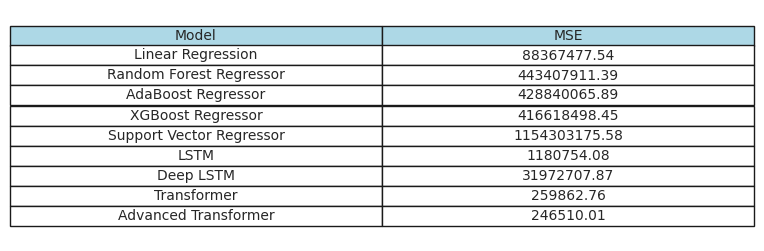

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = mse_df

# Improve the aesthetics using seaborn
sns.set()

# Create a figure and an axis (which we won't actually use)
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust figsize to fit your DataFrame

# Hide the axes
ax.axis('off')

# Create the table and remove the cell borders
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#ADD8E6"] * df.shape[1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # May need adjustment based on your DataFrame's size

# Save the figure
plt.savefig('/content/dataframe_image.png', bbox_inches='tight', dpi=200)  # Adjust DPI as necessary

# Optionally display the figure in the notebook (if you're using one)
plt.show()


In [24]:
gdp_df = pd.read_csv("/content/saudi-arabia-gross-domestic-product-by-kind-of-economic-activity-at-current-pric.csv", delimiter=';')

# Let's check the first few rows to ensure it's been read correctly.
gdp_df.head(5)

,Periodicity,Date,Year,Quarter,Economic Activity,GDP in Million Saudi Riyal
0,Quarterly,2010-03,2010,Q1,Mining & Quarrying : Other Mining & Quarrying,2188.76
1,Quarterly,2010-03,2010,Q1,Construction,22579.99
2,Quarterly,2010-03,2010,Q1,"Community, Social & Personal Services",9115.01
3,Quarterly,2010-06,2010,Q2,Mining & Quarrying,199180.95
4,Quarterly,2010-06,2010,Q2,Mining & Quarrying : Crude Petroleum & Natural...,197120.82


In [25]:
# Aggregate the quarterly GDP by summing up all sectors for each quarter
quarterly_gdp_sum = gdp_df.groupby(['Year', 'Quarter'])['GDP in Million Saudi Riyal'].sum().reset_index()

# Create a date range for the monthly dates that covers the span of the quarterly data
# Assuming the quarterly data starts from the first month of the first quarter and ends at the last month of the last quarter
start_year = quarterly_gdp_sum['Year'].min()
end_year = quarterly_gdp_sum['Year'].max()
monthly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='M')

# Map each quarter to its corresponding months
quarter_to_months = {
    'Q1': ['-01', '-02', '-03'],
    'Q2': ['-04', '-05', '-06'],
    'Q3': ['-07', '-08', '-09'],
    'Q4': ['-10', '-11', '-12'],
}

# Expand the quarterly GDP to monthly by averaging over the three months in each quarter
monthly_gdp = []
for i, row in quarterly_gdp_sum.iterrows():
    for month_suffix in quarter_to_months[row['Quarter']]:
        monthly_gdp.append({
            'Date': pd.to_datetime(f"{row['Year']}{month_suffix}"),
            'Monthly GDP in Million Saudi Riyal': row['GDP in Million Saudi Riyal'] / 3
        })

monthly_gdp_df = pd.DataFrame(monthly_gdp)

# Ensure the monthly GDP dataframe is sorted by date
monthly_gdp_df = monthly_gdp_df.sort_values(by='Date').reset_index(drop=True)

monthly_gdp_df.head()


,Date,Monthly GDP in Million Saudi Riyal
0,2010-01-01,575902.520000
1,2010-02-01,575902.520000
2,2010-03-01,575902.520000
3,2010-04-01,575501.543333
4,2010-05-01,575501.543333


In [26]:
df = pd.read_csv('/content/Exports value by harmonized system.csv')

In [27]:
# Recreate necessary preprocessing steps for the export data to generate `total_export_values`

# Dropping the 'HS Chapter Code' and 'HS Chapter' columns as per the initial preprocessing steps
df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)

# Aggregating the data by 'HS Section' and summing the values for each month
aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()

# Melting the dataframe to have 'Month' as one of the columns
melted_df = pd.melt(aggregated_data, id_vars=['HS Section'], var_name='Month', value_name='Export_Value')

# Converting 'Month' to datetime format
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

# Pivoting the dataframe to have monthly data for each 'HS Section', then summing across all sections to get total export values
pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)

# Merging with monthly GDP data
merged_df = pd.merge(total_export_values.to_frame(name='Total Export Value'), monthly_gdp_df, left_index=True, right_on='Date', how='inner')

# Sorting and preparing the dataframe
merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

merged_df.head()


,Total Export Value,Date,Monthly GDP in Million Saudi Riyal
0,58448.224268,2015-01-01,758085.086667
1,61615.750266,2015-02-01,758085.086667
2,72785.730319,2015-03-01,758085.086667
3,73786.925169,2015-04-01,762555.403333
4,76856.243438,2015-05-01,762555.403333


In [28]:
merged_df.isnull().sum()

,0
Total Export Value,0
Date,0
Monthly GDP in Million Saudi Riyal,0


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Embedding, Flatten
from tensorflow.keras.optimizers import Adam

# Assuming merged_df is your final DataFrame after merging GDP and export values
# and that it has been correctly prepared up to this point
def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'


reset_random_seeds()
# Normalize both Total Export Value and Monthly GDP features
features = merged_df[['Total Export Value', 'Monthly GDP in Million Saudi Riyal']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
# Update the series_to_supervised function to handle multiple features
def series_to_supervised(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in), :])
        y.append(data[i + n_in, 0])
    return np.array(X), np.array(y)


n_input = 1
train_X, train_y = series_to_supervised(scaled_features[:-12], n_in=n_input)
test_X, test_y = series_to_supervised(scaled_features[-(n_input+30):], n_in=n_input)


train_X = train_X.reshape((train_X.shape[0], n_input, -1))
test_X = test_X.reshape((test_X.shape[0], n_input, -1))
inputs = Input(shape=(n_input, train_X.shape[2]))
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = Flatten()(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


history = transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)


Epoch 1/400
3/3 - 2s - loss: 0.0179 - val_loss: 0.0109 - 2s/epoch - 776ms/step
Epoch 2/400
3/3 - 0s - loss: 0.0141 - val_loss: 0.0145 - 40ms/epoch - 13ms/step
Epoch 3/400
3/3 - 0s - loss: 0.0176 - val_loss: 0.0262 - 57ms/epoch - 19ms/step
Epoch 4/400
3/3 - 0s - loss: 0.0243 - val_loss: 0.0222 - 42ms/epoch - 14ms/step
Epoch 5/400
3/3 - 0s - loss: 0.0157 - val_loss: 0.0279 - 42ms/epoch - 14ms/step
Epoch 6/400
3/3 - 0s - loss: 0.0203 - val_loss: 0.0219 - 43ms/epoch - 14ms/step
Epoch 7/400
3/3 - 0s - loss: 0.0247 - val_loss: 0.0116 - 42ms/epoch - 14ms/step
Epoch 8/400
3/3 - 0s - loss: 0.0150 - val_loss: 0.0121 - 41ms/epoch - 14ms/step
Epoch 9/400
3/3 - 0s - loss: 0.0149 - val_loss: 0.0115 - 41ms/epoch - 14ms/step
Epoch 10/400
3/3 - 0s - loss: 0.0184 - val_loss: 0.0099 - 59ms/epoch - 20ms/step
Epoch 11/400
3/3 - 0s - loss: 0.0134 - val_loss: 0.0113 - 52ms/epoch - 17ms/step
Epoch 12/400
3/3 - 0s - loss: 0.0190 - val_loss: 0.0115 - 56ms/epoch - 19ms/step
Epoch 13/400
3/3 - 0s - loss: 0.0145 -

1/1 [==============================] - 1s 737ms/step


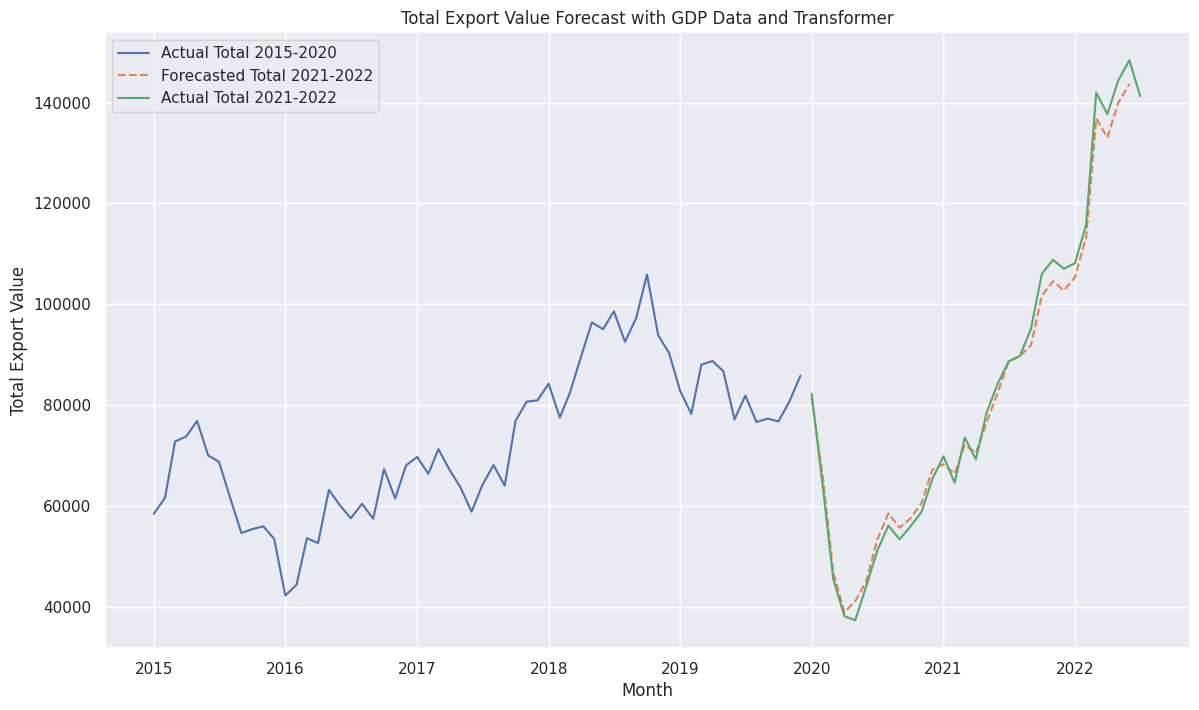

In [30]:
yhat = transformer_model.predict(test_X)

dummy_gdp_predictions = np.zeros((yhat.shape[0], 1))
predictions_with_dummy = np.concatenate([yhat, dummy_gdp_predictions], axis=1)


inv_predictions_with_dummy = scaler.inverse_transform(predictions_with_dummy)


inv_yhat = inv_predictions_with_dummy[:, 0]



plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with GDP Data and Transformer')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_transformer_with_gdp_data = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse_transformer_with_gdp_data)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("GDP Data Transfomer")
print(f'MSE: {mse_transformer_with_gdp_data}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')




GDP Data Transfomer
MSE: 7786541.04042933
RMSE: 2790.4374281516025
MAD: 2399.6247176040706
MAPE: 2.991993026849241%


In [ ]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import os
# import random as python_random
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Embedding, Flatten
# from tensorflow.keras.optimizers import Adam

# # Assuming merged_df is your DataFrame
# def reset_random_seeds(seed_value=42):
#     np.random.seed(seed_value)
#     python_random.seed(seed_value)
#     tf.random.set_seed(seed_value)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'

# reset_random_seeds()

# # Create a new feature by multiplying 'Total Export Value' and 'Monthly GDP in Million Saudi Riyal'
# merged_df['Combined Feature'] = merged_df['Total Export Value'] * merged_df['Monthly GDP in Million Saudi Riyal']
# features = merged_df[['Combined Feature']].values  # Use only the new combined feature
# merged_df.head()

# # Split the DataFrame into training and testing sets based on date
# train_df = merged_df.loc[:'2019-12-31']
# test_df = merged_df.loc['2020-01-01':]

# # Scale the 'Combined Feature' separately for training and testing to prevent data leakage
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train = scaler.fit_transform(train_df['Combined Feature'].values.reshape(-1, 1))
# scaled_test = scaler.transform(test_df['Combined Feature'].values.reshape(-1, 1))

# # Convert the scaled data into supervised learning format
# train_X, train_y = series_to_supervised(scaled_train, n_in=1)
# test_X, test_y = series_to_supervised(scaled_test, n_in=1)

# # Reshape input to be 3D [samples, timesteps, features] for the transformer model
# train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# # Assuming your transformer_encoder function is defined as before...
# # Now define the model architecture with the adjusted input shape
# inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
# x = transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=64, dropout=0.1)
# x = Flatten()(x)
# outputs = Dense(1)(x)

# complex_transformer_model = Model(inputs, outputs)
# complex_transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Train the model
# history = complex_transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)

# # # Normalize the new single feature
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled_features = scaler.fit_transform(features)

# # # Update the series_to_supervised function for a single feature
# # def series_to_supervised(data, n_in=1, n_out=1):
# #     X, y = [], []
# #     for i in range(len(data) - n_in - n_out + 1):
# #         X.append(data[i:(i + n_in), :])
# #         y.append(data[i + n_in])
# #     return np.array(X), np.array(y)

# # n_input = 1
# # train_X, train_y = series_to_supervised(scaled_features[:-12], n_in=n_input)
# # test_X, test_y = series_to_supervised(scaled_features[-(n_input+12):], n_in=n_input)

# # train_X = train_X.reshape((train_X.shape[0], n_input, -1))
# # test_X = test_X.reshape((test_X.shape[0], n_input, -1))

# # # Define a transformer encoder block as it seems missing from the original code snippet
# # def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
# #     # Attention and normalization
# #     x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
# #     x = Dropout(dropout)(x)
# #     x = LayerNormalization(epsilon=1e-6)(x)
# #     # Feed-forward and normalization
# #     ff = Dense(ff_dim, activation="relu")(x)
# #     ff = Dropout(dropout)(ff)
# #     x = LayerNormalization(epsilon=1e-6)(ff)
# #     return x

# # inputs = Input(shape=(n_input, train_X.shape[2]))
# # x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
# # x = Flatten()(x)
# # outputs = Dense(1)(x)

# # transformer_model = Model(inputs, outputs)
# # transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # history = transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)


In [ ]:
# # Split the DataFrame into training and testing sets based on date
# train_df = merged_df.loc[:'2019-12-31']
# test_df = merged_df.loc['2020-01-01':]

# # Scale the 'Combined Feature' separately for training and testing to prevent data leakage
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train = scaler.fit_transform(train_df['Combined Feature'].values.reshape(-1, 1))
# scaled_test = scaler.transform(test_df['Combined Feature'].values.reshape(-1, 1))

# # Convert the scaled data into supervised learning format
# train_X, train_y = series_to_supervised(scaled_train, n_in=1)
# test_X, test_y = series_to_supervised(scaled_test, n_in=1)

# # Reshape input to be 3D [samples, timesteps, features] for the transformer model
# train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# # Assuming your transformer_encoder function is defined as before...
# # Now define the model architecture with the adjusted input shape
# inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
# x = transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=64, dropout=0.1)
# x = Flatten()(x)
# outputs = Dense(1)(x)

# complex_transformer_model = Model(inputs, outputs)
# complex_transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Train the model
# history = complex_transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)


In [ ]:
# yhat = complex_transformer_model.predict(test_X)

# dummy_gdp_predictions = np.zeros((yhat.shape[0], 1))
# predictions_with_dummy = np.concatenate([yhat, dummy_gdp_predictions], axis=1)


# inv_predictions_with_dummy = scaler.inverse_transform(predictions_with_dummy)


# inv_yhat = inv_predictions_with_dummy[:, 0]



# plt.figure(figsize=(14, 8))
# plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
# plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
# plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
# plt.title('Total Export Value Forecast with Advanced Transformer')
# plt.xlabel('Month')
# plt.ylabel('Total Export Value')
# plt.legend()
# plt.show()

Stacking

In [ ]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # Define the base models
# rf_regressor = RandomForestRegressor(random_state=42, max_depth=None, min_samples_split=2, n_estimators=1000)
# xgb_regressor = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.01, max_depth=5)
# ada_regressor = AdaBoostRegressor(random_state=42, n_estimators=100)

# # Define the stacking model with a meta-learner (Ridge in this case)
# stacking_model = StackingRegressor(
#     estimators=[
#         ('rf', rf_regressor),
#         ('xgb', xgb_regressor),
#         ('ada', ada_regressor)
#     ],
#     final_estimator=Ridge(alpha=10)  # Adjust alpha for regularization strength
# )

# # Fit the stacking model
# stacking_model.fit(X_train, y_train)

# # Make predictions
# stacked_predictions = stacking_model.predict(X_test)

# # Evaluate the model performance
# mse = mean_squared_error(y_test, stacked_predictions)
# print("Mean Squared Error of Stacked Model with Ridge Regression as Meta-Learner:", mse)

# # Plot the results
# plt.figure(figsize=(14, 8))
# plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
# plt.plot(forecast_dates, stacked_predictions, label='Stacked Model Forecast with Ridge', linestyle='--', color='green')

# plt.title('Total Export Value Forecast with Stacking Model (Ridge Regression as Meta-Learner)')
# plt.xlabel('Month')
# plt.ylabel('Total Export Value')
# plt.legend()
# plt.show()


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Assuming `stacked_predictions` is the forecasted output from the stacking model
# # and `y_test` is the actual target values for the test set

# actual = y_test.values.flatten()  # Flatten actual values
# forecasted = stacked_predictions.flatten()  # Flatten forecasted values

# # MSE
# mse = mean_squared_error(actual, forecasted)

# # RMSE
# rmse = np.sqrt(mse)

# # MAD
# mad = mean_absolute_error(actual, forecasted)

# # MAPE
# mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

# print("Stacked Model Performance")
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')
# print(f'MAD: {mad}')
# print(f'MAPE: {mape}%')


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Predictions on the training set
# train_predictions = stacking_model.predict(X_train)

# # Predictions on the test set
# test_predictions = stacking_model.predict(X_test)

# # Calculate metrics for training set
# train_mse = mean_squared_error(y_train, train_predictions)
# train_mae = mean_absolute_error(y_train, train_predictions)

# # Calculate metrics for test set
# test_mse = mean_squared_error(y_test, test_predictions)
# test_mae = mean_absolute_error(y_test, test_predictions)

# print("Training Set Performance:")
# print(f'MSE: {train_mse}')
# print(f'MAE: {train_mae}')

# print("\nTest Set Performance:")
# print(f'MSE: {test_mse}')
# print(f'MAE: {test_mae}')


In [ ]:
# from sklearn.model_selection import cross_val_score

# cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
# mean_cv_score = -cv_scores.mean()

# print("Cross-Validation MSE:", mean_cv_score)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from xgboost import XGBRegressor

# # Define the base models
# rf_regressor = RandomForestRegressor(random_state=42)
# xgb_regressor = XGBRegressor(random_state=42)
# ada_regressor = AdaBoostRegressor(random_state=42)

# # Define the stacking model
# stacking_model = StackingRegressor(
#     estimators=[
#         ('rf', rf_regressor),
#         ('xgb', xgb_regressor),
#         ('ada', ada_regressor)
#     ],
#     final_estimator=Ridge()  # Ridge as the meta-learner
# )

# # Define the parameter grid
# param_grid = {
#     'final_estimator__alpha': [0.1, 1, 10, 20],  # Regularization strengths for Ridge
#     'xgb__learning_rate': [0.01, 0.05, 0.1],
#     'xgb__max_depth': [3, 5, 7],
#     'rf__n_estimators': [100, 500],
#     'ada__n_estimators': [50, 100, 200]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=stacking_model,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',  # Use MSE as evaluation metric
#     n_jobs=-1,  # Use all available cores
#     verbose=2
# )

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Retrieve the best model and parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best parameters found: ", best_params)
# print("Best mean cross-validated score (negative MSE):", grid_search.best_score_)

# # Evaluate on the test set
# test_predictions = best_model.predict(X_test)
# test_mse = mean_squared_error(y_test, test_predictions)
# print("Test MSE with best model:", test_mse)


Stacking Model (Ridge Regression as Meta-Learner)

Mean Squared Error of Stacked Model with Ridge Regression as Meta-Learner: 469002748.60508716


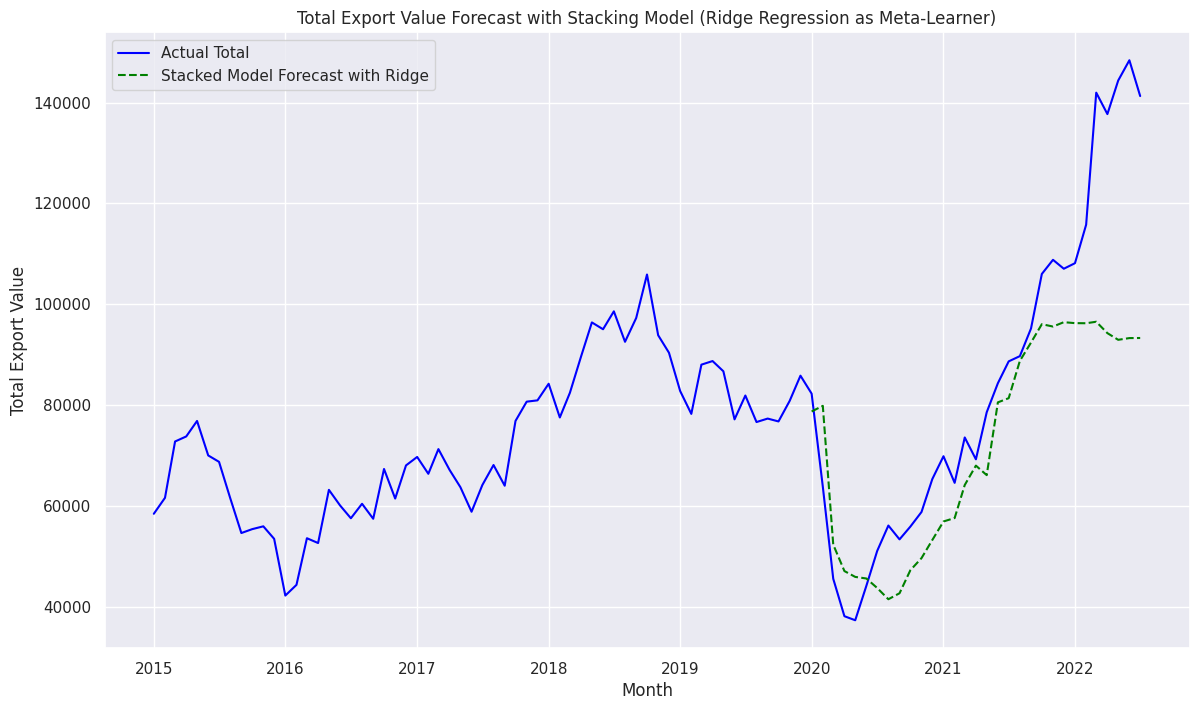

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

ada_regressor.fit(X_train, y_train)

# Define the base models
rf_regressor = RandomForestRegressor(random_state=42, max_depth=None, min_samples_split=2, n_estimators=500)
xgb_regressor = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.05, max_depth=5)
ada_regressor = AdaBoostRegressor(random_state=42, n_estimators=100)

# Define the stacking model with a meta-learner (Ridge in this case)
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_regressor),
        ('xgb', xgb_regressor),
        ('ada', ada_regressor)
            ],
    final_estimator=Ridge(alpha=20)  # Adjust alpha for regularization strength
)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
stacked_predictions = stacking_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, stacked_predictions)
print("Mean Squared Error of Stacked Model with Ridge Regression as Meta-Learner:", mse)

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
plt.plot(forecast_dates, stacked_predictions, label='Stacked Model Forecast with Ridge', linestyle='--', color='green')

plt.title('Total Export Value Forecast with Stacking Model (Ridge Regression as Meta-Learner)')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming `stacked_predictions` is the forecasted output from the stacking model
# and `y_test` is the actual target values for the test set

actual = y_test.values.flatten()  # Flatten actual values
forecasted = stacked_predictions.flatten()  # Flatten forecasted values

# MSE
mse = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Stacked Model Performance")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')


Stacked Model Performance
MSE: 469002748.60508716
RMSE: 21656.47128700997
MAD: 15301.598230220678
MAPE: 16.454849912072252%


In [ ]:
# from sklearn.metrics import mean_squared_error
# import numpy as np

# rf_regressor.fit(X_train, y_train)
# # Generate predictions on the test set for each base model
# rf_test_predictions = rf_regressor.predict(X_test)
# xgb_test_predictions = xgb_regressor.predict(X_test)
# ada_test_predictions = ada_regressor.predict(X_test)

# # Define weights for each model based on relative performance or intuition
# # You may adjust these weights to optimize the ensemble performance
# rf_weight = 0.5
# xgb_weight = 0.4
# ada_weight = 0.2

# # Compute the weighted average of predictions
# final_predictions = (rf_weight * rf_test_predictions +
#                      xgb_weight * xgb_test_predictions +
#                      ada_weight * ada_test_predictions)

# # Evaluate the performance of the weighted average ensemble
# test_mse = mean_squared_error(y_test, final_predictions)
# print("Test MSE with Weighted Averaging:", test_mse)

# # Plot the results
# plt.figure(figsize=(14, 8))
# plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
# plt.plot(forecast_dates, final_predictions, label='Weighted Averaging Forecast', linestyle='--', color='purple')

# plt.title('Total Export Value Forecast with Weighted Averaging Ensemble')
# plt.xlabel('Month')
# plt.ylabel('Total Export Value')
# plt.legend()
# plt.show()


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Assuming `final_predictions` is the forecasted output from the weighted averaging model
# # and `y_test` is the actual target values for the test set

# actual = y_test.values.flatten()  # Flatten actual values
# forecasted = final_predictions.flatten()  # Flatten forecasted values

# # MSE
# mse = mean_squared_error(actual, forecasted)

# # RMSE
# rmse = np.sqrt(mse)

# # MAD
# mad = mean_absolute_error(actual, forecasted)

# # MAPE
# # Adding a small epsilon to avoid division by zero for MAPE calculation
# epsilon = 1e-10
# mape = np.mean(np.abs((actual - forecasted) / (actual + epsilon))) * 100

# print("Weighted Averaging Model Performance")
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')
# print(f'MAD: {mad}')
# print(f'MAPE: {mape}%')


Non-Linear Blending Ensemble

Test MSE with XGBRegressor as Meta-Learner: 1698952.7178162185


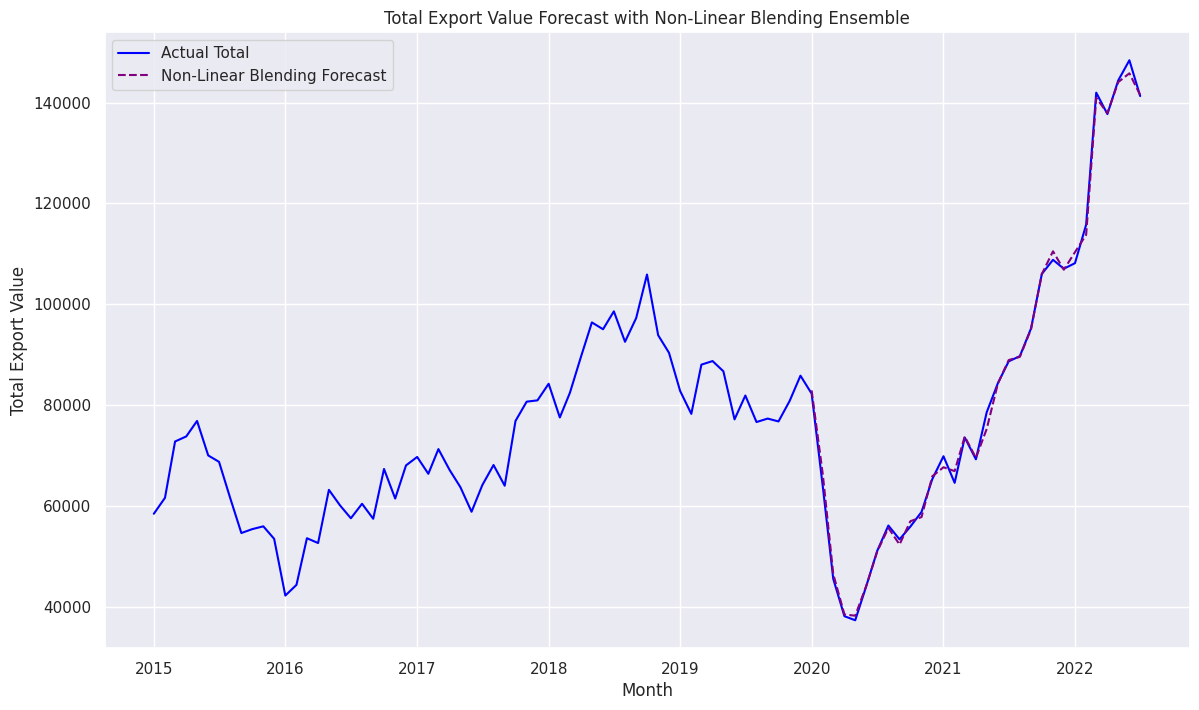

In [ ]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

rf_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)
ada_regressor.fit(X_train, y_train)
# Generate predictions on the test set for each base model
rf_test_predictions = rf_regressor.predict(X_test)
xgb_test_predictions = xgb_regressor.predict(X_test)
ada_test_predictions = ada_regressor.predict(X_test)

# Stack predictions as features for the meta-learner
meta_features = np.column_stack((rf_test_predictions, xgb_test_predictions, ada_test_predictions))

# Define and train the meta-learner
meta_learner = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
meta_learner.fit(meta_features, y_test)

# Make final predictions using the meta-learner
final_predictions = meta_learner.predict(meta_features)

# Evaluate the performance of the non-linear blending ensemble
test_mse = mean_squared_error(y_test, final_predictions)
print("Test MSE with XGBRegressor as Meta-Learner:", test_mse)

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
plt.plot(forecast_dates, final_predictions, label='Non-Linear Blending Forecast', linestyle='--', color='purple')

plt.title('Total Export Value Forecast with Non-Linear Blending Ensemble')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming `final_predictions` is the forecasted output from the non-linear blending model
# and `y_test` is the actual target values for the test set

actual = y_test.values.flatten()  # Flatten actual values
forecasted = final_predictions.flatten()  # Flatten forecasted values

# MSE
mse = mean_squared_error(actual, forecasted)

# RMSE
rmse = np.sqrt(mse)

# MAD
mad = mean_absolute_error(actual, forecasted)

# MAPE
# Adding a small epsilon to avoid division by zero for MAPE calculation
epsilon = 1e-10
mape = np.mean(np.abs((actual - forecasted) / (actual + epsilon))) * 100

print("Non-Linear Blending Model Performance")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAD: {mad}')
print(f'MAPE: {mape}%')


Non-Linear Blending Model Performance
MSE: 1698952.7178162185
RMSE: 1303.438804783799
MAD: 931.2763193870937
MAPE: 1.234941664942648%


Transperancy

Model Performance Metrics:
MSE: 1698952.7178162185
RMSE: 1303.438804783799
MAD: 931.2763193870937
MAPE: 1.234941664942648%


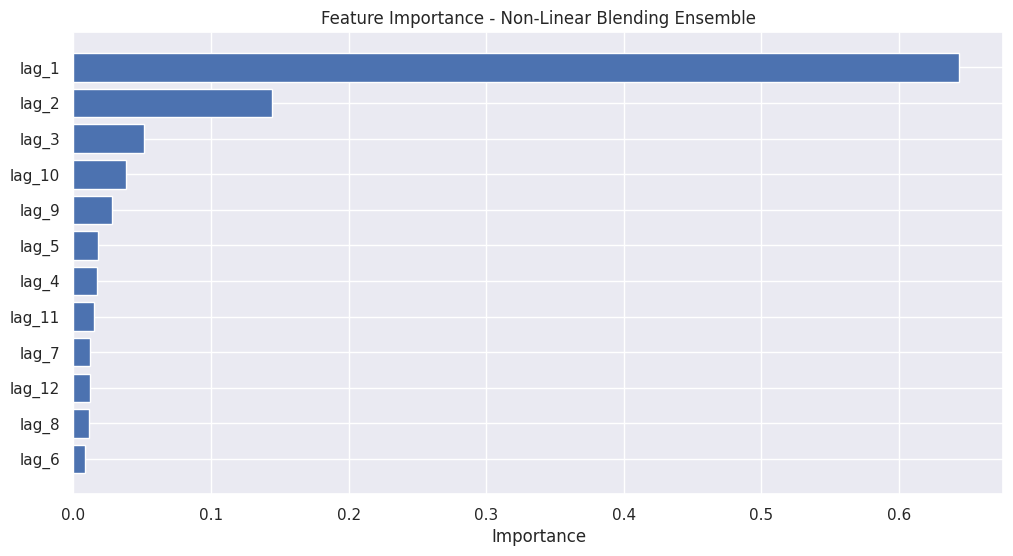

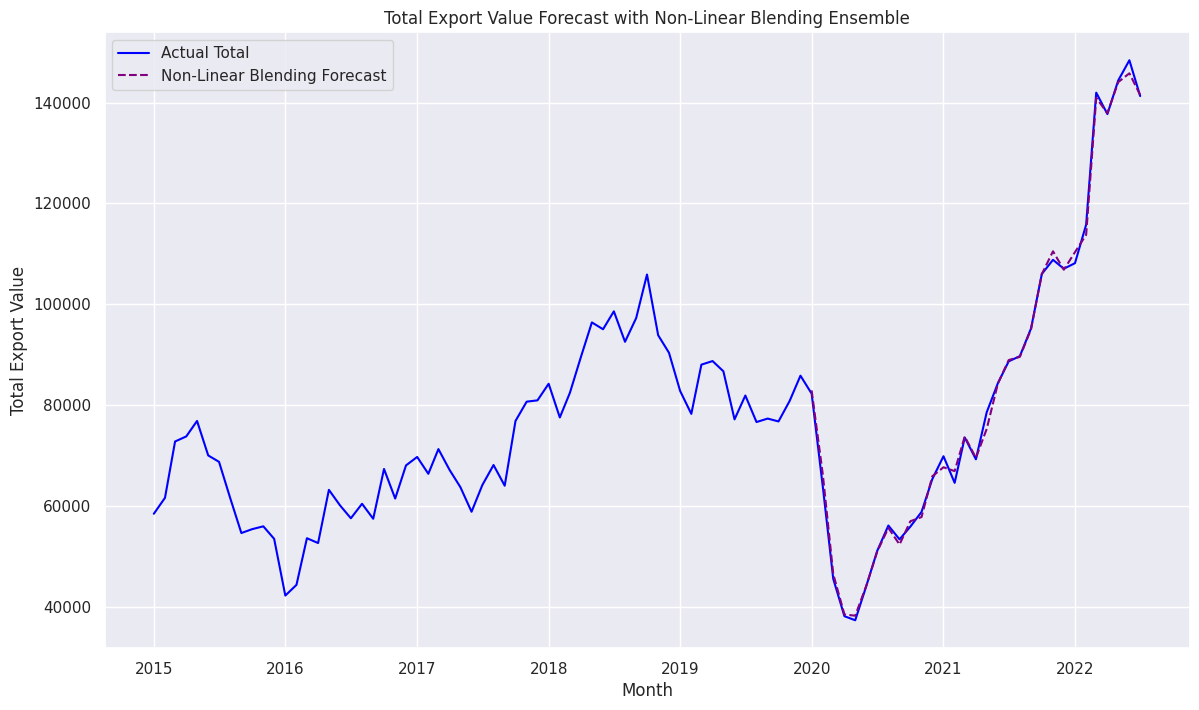

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Train base models
xgb_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
ada_regressor.fit(X_train, y_train)

# Generate predictions on the test set for each base model
rf_test_predictions = rf_regressor.predict(X_test)
xgb_test_predictions = xgb_regressor.predict(X_test)
ada_test_predictions = ada_regressor.predict(X_test)

# Stack predictions as features for the meta-learner
meta_features = np.column_stack((rf_test_predictions, xgb_test_predictions, ada_test_predictions))

# Define and train the meta-learner
meta_learner = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
meta_learner.fit(meta_features, y_test)

# Make final predictions using the meta-learner
final_predictions = meta_learner.predict(meta_features)

# --- Transparency: Performance Metrics ---
def evaluate_model_performance(actual, forecasted):
    """
    Evaluate and display model performance metrics.
    """
    actual = actual.flatten()
    forecasted = forecasted.flatten()

    mse = mean_squared_error(actual, forecasted)
    rmse = np.sqrt(mse)
    mad = mean_absolute_error(actual, forecasted)
    epsilon = 1e-10  # Avoid division by zero
    mape = np.mean(np.abs((actual - forecasted) / (actual + epsilon))) * 100

    print("Model Performance Metrics:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAD: {mad}")
    print(f"MAPE: {mape}%")
    return mse, rmse, mad, mape

# Evaluate the meta-learner's performance
actual = y_test.values
forecasted = final_predictions
evaluate_model_performance(actual, forecasted)

# --- Transparency: Feature Importance ---
def visualize_feature_importance(model, feature_names):
    """
    Visualize feature importance from a trained model.
    """
    try:
        feature_importances = model.feature_importances_
        importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 6))
        plt.barh(importances_df['Feature'], importances_df['Importance'])
        plt.gca().invert_yaxis()
        plt.title('Feature Importance - Non-Linear Blending Ensemble')
        plt.xlabel('Importance')
        plt.show()
        return importances_df
    except AttributeError:
        print("The provided model does not have a feature_importances_ attribute.")
        return None

# Visualize feature importance from the Random Forest base model
visualize_feature_importance(rf_regressor, X_train.columns)

# --- Plot the results ---
plt.figure(figsize=(14, 8))
plt.plot(total_export_values.index, total_export_values.values, label='Actual Total', color='blue')
plt.plot(forecast_dates, final_predictions, label='Non-Linear Blending Forecast', linestyle='--', color='purple')

plt.title('Total Export Value Forecast with Non-Linear Blending Ensemble')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()


Partial Dependence Plots

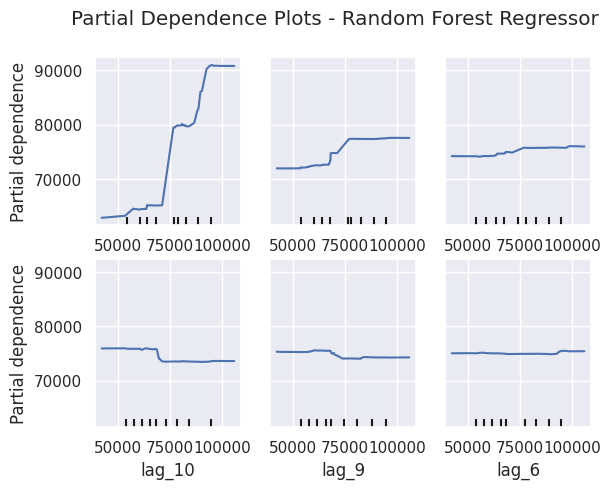

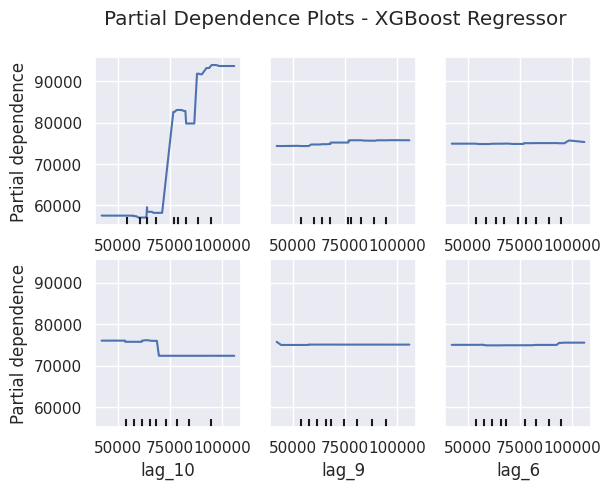

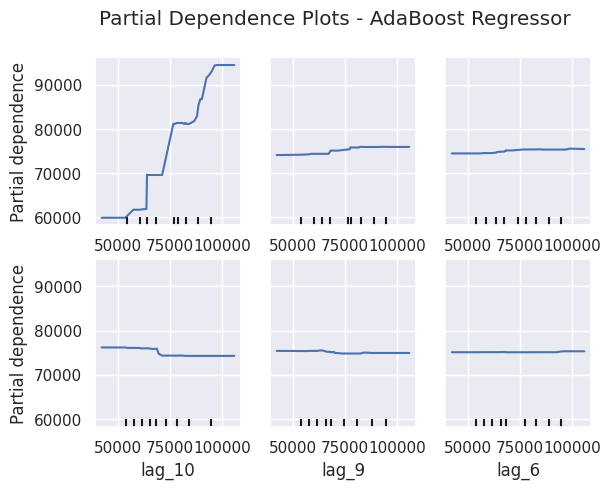

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming `rf_regressor`, `xgb_regressor`, and `ada_regressor` are the base models
# and `X_train` is your training data with features like 'lag_1', 'lag_2', etc.

# Partial Dependence Plot for Random Forest (rf_regressor)
PartialDependenceDisplay.from_estimator(
    rf_regressor, X_train, ['lag_1', 'lag_2', 'lag_3', 'lag_10', 'lag_9', 'lag_6'],
    grid_resolution=50
)
plt.suptitle("Partial Dependence Plots - Random Forest Regressor")
plt.show()

# Partial Dependence Plot for XGBoost (xgb_regressor)
PartialDependenceDisplay.from_estimator(
    xgb_regressor, X_train, ['lag_1', 'lag_2', 'lag_3', 'lag_10', 'lag_9', 'lag_6'],
    grid_resolution=50
)
plt.suptitle("Partial Dependence Plots - XGBoost Regressor")
plt.show()

# Partial Dependence Plot for AdaBoost (ada_regressor)
PartialDependenceDisplay.from_estimator(
    ada_regressor, X_train, ['lag_1', 'lag_2', 'lag_3', 'lag_10', 'lag_9', 'lag_6'],
    grid_resolution=50
)
plt.suptitle("Partial Dependence Plots - AdaBoost Regressor")
plt.show()


Transperancy - Transformer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Reset Random Seeds for Reproducibility ---
def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    import random as python_random
    import tensorflow as tf
    import os
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

reset_random_seeds()

# Normalize features
features = merged_df[['Total Export Value', 'Monthly GDP in Million Saudi Riyal']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert time series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(len(data) - n_in - n_out + 1):
        X.append(data[i:(i + n_in), :])
        y.append(data[i + n_in, 0])
    return np.array(X), np.array(y)

n_input = 1
train_X, train_y = series_to_supervised(scaled_features[:-12], n_in=n_input)
test_X, test_y = series_to_supervised(scaled_features[-(n_input+30):], n_in=n_input)

# Reshape inputs for the Transformer model
train_X = train_X.reshape((train_X.shape[0], n_input, -1))
test_X = test_X.reshape((test_X.shape[0], n_input, -1))


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.optimizers import Adam

# --- Transformer Encoder ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer encoder with residual connections and input projection.
    """
    # Project inputs to match head_size for residual connection
    inputs_proj = Dense(head_size)(inputs)

    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs_proj, inputs_proj)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = x + inputs_proj  # Residual connection

    # Feed-forward network
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = LayerNormalization(epsilon=1e-6)(x_ff)
    return x_ff + x  # Residual connection

# --- Build Transformer Model ---
inputs = Input(shape=(n_input, train_X.shape[2]))  # Shape: [batch_size, n_input, num_features]
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=64, dropout=0.1)
x = Flatten()(x)
outputs = Dense(1)(x)

# Define and compile the model
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = transformer_model.fit(train_X, train_y, epochs=400, batch_size=32, validation_data=(test_X, test_y), verbose=2)


Epoch 1/400
3/3 - 3s - loss: 30.3603 - val_loss: 0.9536 - 3s/epoch - 981ms/step
Epoch 2/400
3/3 - 0s - loss: 2.8085 - val_loss: 6.6358 - 77ms/epoch - 26ms/step
Epoch 3/400
3/3 - 0s - loss: 5.1782 - val_loss: 1.2514 - 70ms/epoch - 23ms/step
Epoch 4/400
3/3 - 0s - loss: 1.2339 - val_loss: 0.3191 - 71ms/epoch - 24ms/step
Epoch 5/400
3/3 - 0s - loss: 0.7280 - val_loss: 1.6578 - 70ms/epoch - 23ms/step
Epoch 6/400
3/3 - 0s - loss: 1.2596 - val_loss: 1.8698 - 79ms/epoch - 26ms/step
Epoch 7/400
3/3 - 0s - loss: 1.3682 - val_loss: 0.9677 - 89ms/epoch - 30ms/step
Epoch 8/400
3/3 - 0s - loss: 0.6418 - val_loss: 0.2501 - 119ms/epoch - 40ms/step
Epoch 9/400
3/3 - 0s - loss: 0.3312 - val_loss: 0.1025 - 88ms/epoch - 29ms/step
Epoch 10/400
3/3 - 0s - loss: 0.7253 - val_loss: 0.1414 - 66ms/epoch - 22ms/step
Epoch 11/400
3/3 - 0s - loss: 0.5116 - val_loss: 0.1225 - 92ms/epoch - 31ms/step
Epoch 12/400
3/3 - 0s - loss: 0.4337 - val_loss: 0.1065 - 96ms/epoch - 32ms/step
Epoch 13/400
3/3 - 0s - loss: 0.3489

1/1 [==============================] - 0s 186ms/step
Model Performance Metrics:
MSE: 0.02042207797169793
RMSE: 0.14290583603092608
MAD: 0.11053849171469711


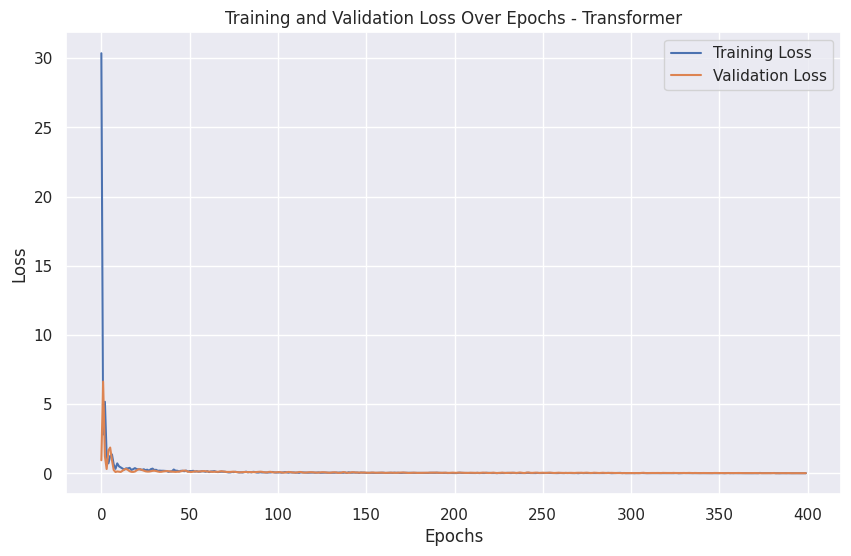

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Transparency: Performance Metrics ---
def evaluate_model_performance(actual, forecasted):
    mse = mean_squared_error(actual, forecasted)
    rmse = np.sqrt(mse)
    mad = mean_absolute_error(actual, forecasted)

    print("Model Performance Metrics:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAD: {mad}")
    return mse, rmse, mad

# Evaluate the model
forecasted = transformer_model.predict(test_X).flatten()
actual = test_y.flatten()
evaluate_model_performance(actual, forecasted)

# --- Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs - Transformer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt

# # --- SHAP for Base Models ---
# print("SHAP for Base Models")

# # SHAP for Random Forest (rf_regressor)
# explainer_rf = shap.TreeExplainer(rf_regressor)
# shap_values_rf = explainer_rf.shap_values(X_test)

# shap.initjs()
# print("Random Forest SHAP Force Plot")
# shap.force_plot(
#     explainer_rf.expected_value,
#     shap_values_rf[0],  # SHAP values for the first sample
#     X_test.iloc[0]      # Feature values for the first sample
# )

# # SHAP for XGBoost (xgb_regressor)
# explainer_xgb = shap.TreeExplainer(xgb_regressor)
# shap_values_xgb = explainer_xgb.shap_values(X_test)

# print("XGBoost SHAP Force Plot")
# shap.force_plot(
#     explainer_xgb.expected_value,
#     shap_values_xgb[0],
#     X_test.iloc[0]
# )

# # --- SHAP for Meta-Learner ---
# print("SHAP for Meta-Learner")

# # Stack predictions from all base models as features for the meta-learner
# rf_predictions = rf_regressor.predict(X_test).reshape(-1, 1)
# xgb_predictions = xgb_regressor.predict(X_test).reshape(-1, 1)
# # Add predictions from AdaBoost if it was part of the training
# ada_predictions = ada_regressor.predict(X_test).reshape(-1, 1)

# # Combine all base model predictions into meta_features
# meta_features = np.hstack((rf_predictions, xgb_predictions, ada_predictions))

# # Debug: Check shape of meta_features
# print(f"Meta-Features Shape: {meta_features.shape}")  # Should match the meta-learner's training

# # KernelExplainer for Meta-Learner
# explainer_meta = shap.KernelExplainer(meta_learner.predict, meta_features)
# shap_values_meta = explainer_meta.shap_values(meta_features)

# # Ensure proper handling of expected values and feature dimensions
# if isinstance(explainer_meta.expected_value, float):
#     expected_value_meta = explainer_meta.expected_value  # Single scalar for expected value
# else:
#     expected_value_meta = explainer_meta.expected_value[0]  # Use the first value if it's an array

# # Plot SHAP values for the meta-learner
# print("Meta-Learner SHAP Force Plot")
# shap.force_plot(
#     expected_value_meta,  # Expected value for the meta-learner
#     shap_values_meta[0],  # SHAP values for the first sample
#     meta_features[0]      # Feature values for the first sample
# )


In [ ]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Stack predictions from base models as features for the meta-learner
# rf_predictions = rf_regressor.predict(X_test).reshape(-1, 1)
# xgb_predictions = xgb_regressor.predict(X_test).reshape(-1, 1)
# ada_predictions = ada_regressor.predict(X_test).reshape(-1, 1)

# # Combine base model predictions into meta_features DataFrame with labeled columns
# meta_features = pd.DataFrame(
#     np.hstack((rf_predictions, xgb_predictions, ada_predictions)),
#     columns=['Random Forest', 'XGBoost', 'AdaBoost']  # Label each column by model name
# )

# # Debug: Check meta_features with labels
# print(meta_features.head())

# # KernelExplainer for Meta-Learner
# explainer_meta = shap.KernelExplainer(meta_learner.predict, meta_features)
# shap_values_meta = explainer_meta.shap_values(meta_features)

# # Ensure proper handling of expected values and feature dimensions
# if isinstance(explainer_meta.expected_value, float):
#     expected_value_meta = explainer_meta.expected_value  # Single scalar for expected value
# else:
#     expected_value_meta = explainer_meta.expected_value[0]  # Use the first value if it's an array

# # Plot SHAP values for the meta-learner with labeled features
# print("Meta-Learner SHAP Force Plot")
# shap.force_plot(
#     expected_value_meta,      # Expected value for the meta-learner
#     shap_values_meta[0],      # SHAP values for the first sample
#     meta_features.iloc[0]     # Feature values for the first sample with labels
# )


In [ ]:
# import shap
# from IPython.display import display

# shap.initjs()  # Initialize JavaScript for SHAP
# display(shap.force_plot(expected_value_meta, shap_values_meta[0], meta_features.iloc[0]))


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize SHAP JavaScript
shap.initjs()

# --- SHAP for Base Models ---
print("SHAP for Base Models")

# SHAP for Random Forest (rf_regressor)
explainer_rf = shap.TreeExplainer(rf_regressor)
shap_values_rf = explainer_rf.shap_values(X_test)

print("Random Forest SHAP Force Plot")
display(shap.force_plot(
    explainer_rf.expected_value,
    shap_values_rf[0],       # SHAP values for the first sample
    X_test.iloc[0]           # Feature values for the first sample
))

# SHAP for XGBoost (xgb_regressor)
explainer_xgb = shap.TreeExplainer(xgb_regressor)
shap_values_xgb = explainer_xgb.shap_values(X_test)

print("XGBoost SHAP Force Plot")
display(shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[0],
    X_test.iloc[0]
))

# --- SHAP for Meta-Learner ---
print("SHAP for Meta-Learner")

# Stack predictions from all base models as features for the meta-learner
rf_predictions = rf_regressor.predict(X_test).reshape(-1, 1)
xgb_predictions = xgb_regressor.predict(X_test).reshape(-1, 1)
# Include predictions from AdaBoost if it is part of the meta-learner
ada_predictions = ada_regressor.predict(X_test).reshape(-1, 1)

# Combine all base model predictions into meta_features
meta_features = np.hstack((rf_predictions, xgb_predictions, ada_predictions))

# Debug: Check shape of meta_features
print(f"Meta-Features Shape: {meta_features.shape}")  # Should match the meta-learner's training

# KernelExplainer for Meta-Learner
explainer_meta = shap.KernelExplainer(meta_learner.predict, meta_features)
shap_values_meta = explainer_meta.shap_values(meta_features)

# Ensure proper handling of expected values and feature dimensions
if isinstance(explainer_meta.expected_value, float):
    expected_value_meta = explainer_meta.expected_value  # Single scalar for expected value
else:
    expected_value_meta = explainer_meta.expected_value[0]  # Use the first value if it's an array

# Plot SHAP values for the meta-learner
print("Meta-Learner SHAP Force Plot")
display(shap.force_plot(
    expected_value_meta,      # Expected value for the meta-learner
    shap_values_meta[0],      # SHAP values for the first sample
    meta_features[0]          # Feature values for the first sample
))


SHAP for Base Models
Random Forest SHAP Force Plot


XGBoost SHAP Force Plot


SHAP for Meta-Learner
Meta-Features Shape: (31, 3)


  0%|          | 0/31 [00:00<?, ?it/s]

Meta-Learner SHAP Force Plot


In [ ]:
import shap
import numpy as np
import pandas as pd
from IPython.display import display

# Initialize SHAP JavaScript
shap.initjs()

# --- SHAP for Base Models ---
print("SHAP for Base Models")

# SHAP for Random Forest (rf_regressor)
explainer_rf = shap.TreeExplainer(rf_regressor)
shap_values_rf = explainer_rf.shap_values(X_test)

print("Random Forest SHAP Force Plot")
display(shap.force_plot(
    explainer_rf.expected_value,
    shap_values_rf[0],       # SHAP values for the first sample
    X_test.iloc[0]           # Feature values for the first sample
))

# SHAP for XGBoost (xgb_regressor)
explainer_xgb = shap.TreeExplainer(xgb_regressor)
shap_values_xgb = explainer_xgb.shap_values(X_test)

print("XGBoost SHAP Force Plot")
display(shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[0],
    X_test.iloc[0]
))

# --- SHAP for Meta-Learner ---
print("SHAP for Meta-Learner")

# Stack predictions from all base models as features for the meta-learner
rf_predictions = rf_regressor.predict(X_test).reshape(-1, 1)
xgb_predictions = xgb_regressor.predict(X_test).reshape(-1, 1)
ada_predictions = ada_regressor.predict(X_test).reshape(-1, 1)

# Combine all base model predictions into a DataFrame with labeled columns
meta_features = pd.DataFrame(
    np.hstack((rf_predictions, xgb_predictions, ada_predictions)),
    columns=['Random Forest', 'XGBoost', 'AdaBoost']  # Label each column by model name
)

# Debug: Check meta_features with labels
print(meta_features.head())  # This will show labeled columns

# KernelExplainer for Meta-Learner
explainer_meta = shap.KernelExplainer(meta_learner.predict, meta_features)
shap_values_meta = explainer_meta.shap_values(meta_features)

# Ensure proper handling of expected values and feature dimensions
if isinstance(explainer_meta.expected_value, float):
    expected_value_meta = explainer_meta.expected_value  # Single scalar for expected value
else:
    expected_value_meta = explainer_meta.expected_value[0]  # Use the first value if it's an array

# Plot SHAP values for the meta-learner with labeled features
print("Meta-Learner SHAP Force Plot")
display(shap.force_plot(
    expected_value_meta,          # Expected value for the meta-learner
    shap_values_meta[0],          # SHAP values for the first sample
    meta_features.iloc[0]         # Labeled feature values for the first sample
))


SHAP for Base Models
Random Forest SHAP Force Plot


XGBoost SHAP Force Plot


SHAP for Meta-Learner
   Random Forest       XGBoost      AdaBoost
0   81497.772256  79262.984375  80901.366085
1   81386.483108  82635.664062  81348.882834
2   62020.829292  49143.480469  60781.598975
3   54061.027778  47556.730469  49881.679827
4   51547.370703  46271.808594  44353.448352


  0%|          | 0/31 [00:00<?, ?it/s]

Meta-Learner SHAP Force Plot


TFT

In [23]:
import pandas as pd
gdp_df = pd.read_csv("/content/saudi-arabia-gross-domestic-product-by-kind-of-economic-activity-at-current-pric.csv", delimiter=';')
df = pd.read_csv('/content/Exports value by harmonized system.csv')

In [24]:
# Aggregate the quarterly GDP by summing up all sectors for each quarter
quarterly_gdp_sum = gdp_df.groupby(['Year', 'Quarter'])['GDP in Million Saudi Riyal'].sum().reset_index()

# Create a date range for the monthly dates that covers the span of the quarterly data
# Assuming the quarterly data starts from the first month of the first quarter and ends at the last month of the last quarter
start_year = quarterly_gdp_sum['Year'].min()
end_year = quarterly_gdp_sum['Year'].max()
monthly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='M')

# Map each quarter to its corresponding months
quarter_to_months = {
    'Q1': ['-01', '-02', '-03'],
    'Q2': ['-04', '-05', '-06'],
    'Q3': ['-07', '-08', '-09'],
    'Q4': ['-10', '-11', '-12'],
}

# Expand the quarterly GDP to monthly by averaging over the three months in each quarter
monthly_gdp = []
for i, row in quarterly_gdp_sum.iterrows():
    for month_suffix in quarter_to_months[row['Quarter']]:
        monthly_gdp.append({
            'Date': pd.to_datetime(f"{row['Year']}{month_suffix}"),
            'Monthly GDP in Million Saudi Riyal': row['GDP in Million Saudi Riyal'] / 3
        })

monthly_gdp_df = pd.DataFrame(monthly_gdp)

# Ensure the monthly GDP dataframe is sorted by date
monthly_gdp_df = monthly_gdp_df.sort_values(by='Date').reset_index(drop=True)

monthly_gdp_df.head()


<ipython-input-24-7e13b881264a>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_dates = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='M')


,Date,Monthly GDP in Million Saudi Riyal
0,2010-01-01,575902.520000
1,2010-02-01,575902.520000
2,2010-03-01,575902.520000
3,2010-04-01,575501.543333
4,2010-05-01,575501.543333


In [25]:
# Recreate necessary preprocessing steps for the export data to generate `total_export_values`

# Dropping the 'HS Chapter Code' and 'HS Chapter' columns as per the initial preprocessing steps
df.drop(['HS Chapter Code', 'HS Chapter'], axis=1, inplace=True)

# Aggregating the data by 'HS Section' and summing the values for each month
aggregated_data = df.groupby('HS Section', as_index=False)[df.columns[1:]].sum()

# Melting the dataframe to have 'Month' as one of the columns
melted_df = pd.melt(aggregated_data, id_vars=['HS Section'], var_name='Month', value_name='Export_Value')

# Converting 'Month' to datetime format
melted_df['Month'] = pd.to_datetime(melted_df['Month'], format='%Y / %m')

# Pivoting the dataframe to have monthly data for each 'HS Section', then summing across all sections to get total export values
pivot_df = melted_df.pivot_table(index='Month', columns='HS Section', values='Export_Value', aggfunc='sum')
total_export_values = pivot_df.sum(axis=1)
total_export_values.head()
train_series = total_export_values[:'2019-12-31']
test_series = total_export_values['2020-01-01':]

# Merging with monthly GDP data
merged_df = pd.merge(total_export_values.to_frame(name='Total Export Value'), monthly_gdp_df, left_index=True, right_on='Date', how='inner')

# Sorting and preparing the dataframe
merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

merged_df.head()


,Total Export Value,Date,Monthly GDP in Million Saudi Riyal
0,58448.224268,2015-01-01,758085.086667
1,61615.750266,2015-02-01,758085.086667
2,72785.730319,2015-03-01,758085.086667
3,73786.925169,2015-04-01,762555.403333
4,76856.243438,2015-05-01,762555.403333


In [103]:
import numpy as np
import tensorflow as tf
import random as python_random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, LSTM, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam

# Set global random seed for reproducibility
def reset_random_seeds(seed_value=42):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_random_seeds(seed_value=42)

# Define the TFT Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation='relu')(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Define the Temporal Fusion Transformer model
def build_tft_model(n_input, n_features, head_size=64, num_heads=4, ff_dim=64, dropout=0.1, seed=42):
    # Inputs
    inputs = Input(shape=(n_input, n_features))

    # LSTM Encoder with seed
    lstm_out = LSTM(64, return_sequences=True, recurrent_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(inputs)
    lstm_out = Dropout(dropout)(lstm_out)

    # Transformer Encoder
    transformer_out = transformer_encoder(lstm_out, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    # Static Features (if any) can be concatenated here, omitted for simplicity

    # Fully Connected Layers
    x = Flatten()(transformer_out)
    x = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed=seed))(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)  # Predicting Total Export Value

    # Model Compilation
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the TFT model
tft_model = build_tft_model(n_input=n_input, n_features=train_X.shape[2], seed=0)

########
# Update test data split to include +30 time steps
test_X, test_y = series_to_supervised(scaled_features[-(n_input + 30):], n_in=n_input)

# Reshape train and test data for model input
train_X = train_X.reshape((train_X.shape[0], n_input, -1))
test_X = test_X.reshape((test_X.shape[0], n_input, -1))

# Train the model
history = tft_model.fit(
    train_X, train_y,
    epochs=400,
    batch_size=32,
    validation_data=(test_X, test_y),
    verbose=2
)


Epoch 1/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - loss: 1.9423 - val_loss: 0.0890
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2776 - val_loss: 0.1791
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6170 - val_loss: 0.5593
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7754 - val_loss: 0.0776
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5176 - val_loss: 0.1839
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5478 - val_loss: 0.0742
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3614 - val_loss: 0.1224
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3290 - val_loss: 0.0866
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2611 - val_loss: 0.0933
Epoch 10/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2706 - val_loss: 0.1267
Epoch 11/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2304 - val_loss: 0.0689
Epoch 12/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2047 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (30, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


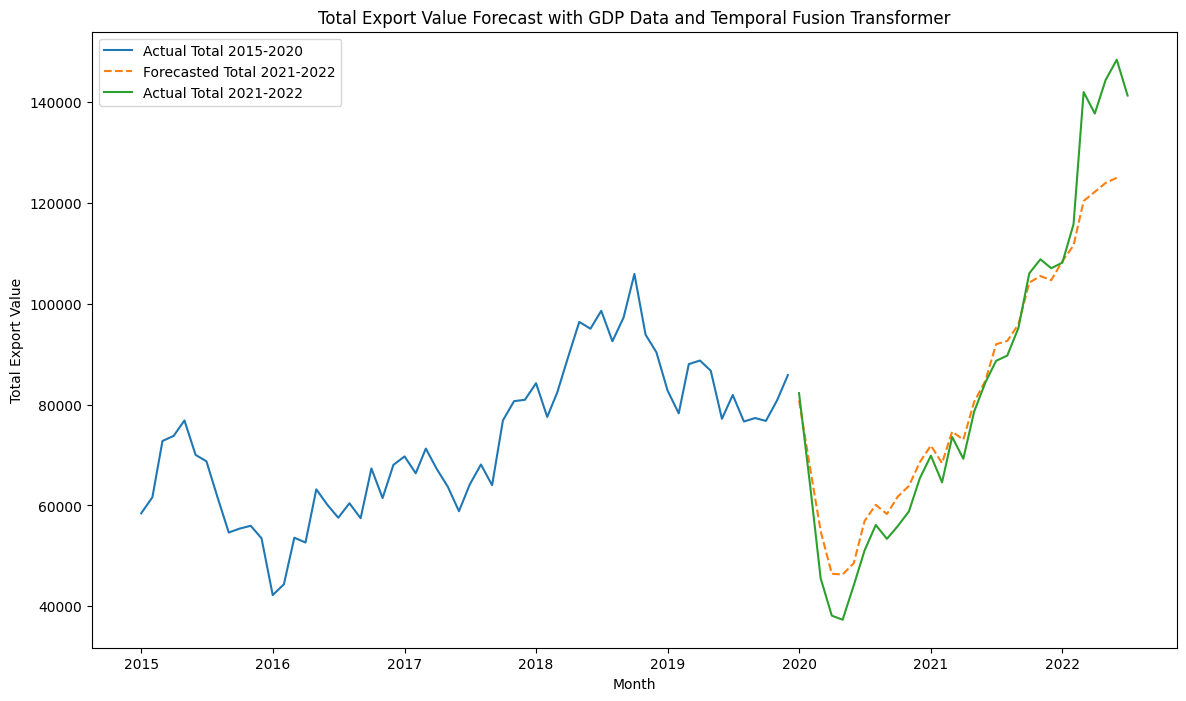

In [104]:
# Generate predictions
yhat = tft_model.predict(test_X)

# Dummy predictions for scaling back (e.g., GDP for normalization process)
dummy_gdp_predictions = np.zeros((yhat.shape[0], 1))
predictions_with_dummy = np.concatenate([yhat, dummy_gdp_predictions], axis=1)

# Inverse transform predictions
inv_predictions_with_dummy = scaler.inverse_transform(predictions_with_dummy)
inv_yhat = inv_predictions_with_dummy[:, 0]

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
plt.plot(test_series.index[:len(inv_yhat)], inv_yhat, label='Forecasted Total 2021-2022', linestyle='--')
plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
plt.title('Total Export Value Forecast with GDP Data and Temporal Fusion Transformer')
plt.xlabel('Month')
plt.ylabel('Total Export Value')
plt.legend()
plt.show()


In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate performance metrics
actual = test_series.values.flatten()[:len(inv_yhat)]
forecasted = inv_yhat.flatten()

# MSE
mse_tft = mean_squared_error(actual, forecasted)

# RMSE
rmse_tft = np.sqrt(mse_tft)

# MAD
mad_tft = mean_absolute_error(actual, forecasted)

# MAPE
mape_tft = np.mean(np.abs((actual - forecasted) / actual)) * 100

print("Temporal Fusion Transformer with GDP Data")
print(f'MSE: {mse_tft}')
print(f'RMSE: {rmse_tft}')
print(f'MAD: {mad_tft}')
print(f'MAPE: {mape_tft}%')


Temporal Fusion Transformer with GDP Data
MSE: 72782515.51053062
RMSE: 8531.266934666306
MAD: 5923.944909084321
MAPE: 7.629096114557981%


In [59]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Add, MultiHeadAttention, LayerNormalization, Flatten
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
# # Load and preprocess the data
# X_data = merged_df[['Total Export Value', 'Monthly GDP in Million Saudi Riyal']].values
# y_data = merged_df['Total Export Value'].values  # Assuming this is the prediction target

# # Scale the features
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(X_data)

# # Transform the data into supervised learning format
# def series_to_supervised(data, n_in=12, n_out=1):
#     X, y = [], []
#     for i in range(len(data) - n_in - n_out + 1):
#         X.append(data[i:i + n_in, :])
#         y.append(data[i + n_in, 0])  # Predicting the target variable
#     return np.array(X), np.array(y)

# # Use the past 12 months for prediction
# n_steps = 30
# X, y = series_to_supervised(X_scaled, n_in=n_steps)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Create additional test data for evaluation
# test_X, test_y = series_to_supervised(X_scaled[-(n_steps + 30):], n_in=n_steps)


In [5]:
# # Build the Temporal Fusion Transformer (TFT) model
# def build_tft_model(input_shape):
#     # Input layer
#     inputs = Input(shape=input_shape)

#     # LSTM Encoder
#     lstm_out = LSTM(64, return_sequences=True)(inputs)
#     lstm_out = LSTM(32, return_sequences=True)(lstm_out)

#     # Multi-Head Attention
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(lstm_out, lstm_out)

#     # Skip Connection
#     combined = Add()([attn_output, lstm_out])

#     # Layer Normalization
#     combined = LayerNormalization()(combined)

#     # Flatten for Dense Layers
#     flattened = Flatten()(combined)

#     # Fully Connected Layers
#     fc = Dense(64, activation='relu')(flattened)
#     fc = Dropout(0.2)(fc)
#     fc = Dense(32, activation='relu')(fc)

#     # Output Layer
#     outputs = Dense(1)(fc)

#     model = Model(inputs, outputs)
#     return model

# # Define model shape and compile
# input_shape = (X_train.shape[1], X_train.shape[2])  # Time steps and features
# model = build_tft_model(input_shape)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# # Model Summary
# model.summary()


In [6]:
# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=400,
#     batch_size=32,
#     verbose=2
# )

In [7]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()


In [8]:
# y_pred = model.predict(X_test)
# # Rescale back to original scale if using MinMaxScaler
# y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, X_test[:, -1, 1:]], axis=1))[:, 0]
# y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1))[:, 0]


In [9]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
# mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# print(f"RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")


In [10]:
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_rescaled, label='Actual', alpha=0.8)
# plt.plot(y_pred_rescaled, label='Predicted', alpha=0.8)
# plt.legend()
# plt.title("Actual vs Predicted Export Values")
# plt.xlabel("Time")
# plt.ylabel("Export Value")
# plt.show()


In [11]:
# # Generate predictions using the trained model
# yhat = model.predict(test_X)

# # Concatenate predictions with the GDP feature for inverse transformation
# # Since 'Monthly GDP' is the second feature, concatenate it with yhat
# predictions_with_gdp = np.concatenate([yhat, test_X[:, -1, 1].reshape(-1, 1)], axis=1)

# # Inverse transform to get predictions back to the original scale
# inv_predictions = scaler.inverse_transform(predictions_with_gdp)

# # Extract the Total Export Value predictions
# inv_yhat = inv_predictions[:, 0]

# # Create a new index for predictions to align with the actual timeline
# forecast_start_index = test_series.index[0]  # Start from the first index of the test series
# forecast_index = pd.date_range(forecast_start_index, periods=len(inv_yhat), freq='M')

# # Visualization of actual vs forecasted values
# plt.figure(figsize=(14, 8))
# plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020', color='blue')
# plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022', color='green')
# plt.plot(forecast_index, inv_yhat, label='Forecasted Total 2021-2022', linestyle='--', color='orange')
# plt.title('Total Export Value Forecast with GDP Data and Transformer')
# plt.xlabel('Year')
# plt.ylabel('Total Export Value')
# plt.legend()
# plt.show()


In [12]:

# # Evaluation Metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Flatten actual and forecasted values for metrics computation
# actual = test_series.values.flatten()[:len(inv_yhat)]
# forecasted = inv_yhat.flatten()

# # Compute metrics
# mse_transformer_with_gdp_data = mean_squared_error(actual, forecasted)
# rmse = np.sqrt(mse_transformer_with_gdp_data)
# mad = mean_absolute_error(actual, forecasted)
# mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

# # Display metrics
# print("GDP Data Transformer")
# print(f'MSE: {mse_transformer_with_gdp_data}')
# print(f'RMSE: {rmse}')
# print(f'MAD: {mad}')
# print(f'MAPE: {mape}%')


In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Add, MultiHeadAttention, LayerNormalization, Flatten
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Load and preprocess the data
# X_data = merged_df[['Total Export Value', 'Monthly GDP in Million Saudi Riyal']].values
# y_data = merged_df['Total Export Value'].values  # Assuming this is the prediction target

# # Scale the features
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(X_data)

# # Transform the data into supervised learning format
# def series_to_supervised(data, n_in=12, n_out=1):
#     X, y = [], []
#     for i in range(len(data) - n_in - n_out + 1):
#         X.append(data[i:i + n_in, :])
#         y.append(data[i + n_in, 0])  # Predicting the target variable
#     return np.array(X), np.array(y)

# # Use the past 12 months for prediction
# n_steps = 30
# X, y = series_to_supervised(X_scaled, n_in=n_steps)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Create additional test data for evaluation
# test_X, test_y = series_to_supervised(X_scaled[-(n_steps + 30):], n_in=n_steps)

# # Build the Temporal Fusion Transformer (TFT) model
# def build_tft_model(input_shape):
#     # Input layer
#     inputs = Input(shape=input_shape)

#     # LSTM Encoder
#     lstm_out = LSTM(64, return_sequences=True)(inputs)
#     lstm_out = LSTM(32, return_sequences=True)(lstm_out)

#     # Multi-Head Attention
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(lstm_out, lstm_out)

#     # Skip Connection
#     combined = Add()([attn_output, lstm_out])

#     # Layer Normalization
#     combined = LayerNormalization()(combined)

#     # Flatten for Dense Layers
#     flattened = Flatten()(combined)

#     # Fully Connected Layers
#     fc = Dense(64, activation='relu')(flattened)
#     fc = Dropout(0.2)(fc)
#     fc = Dense(32, activation='relu')(fc)

#     # Output Layer
#     outputs = Dense(1)(fc)

#     model = Model(inputs, outputs)
#     return model

# # Define model shape and compile
# input_shape = (X_train.shape[1], X_train.shape[2])  # Time steps and features
# model = build_tft_model(input_shape)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# # Model Summary
# model.summary()

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=400,
#     batch_size=32,
#     verbose=2
# )



In [14]:
# # Generate multi-step predictions
# def iterative_forecast(model, initial_input, steps, scaler, n_features=2):
#     predictions = []
#     input_seq = initial_input

#     for _ in range(steps):
#         # Predict the next timestep
#         pred = model.predict(input_seq)
#         predictions.append(pred[0, 0])  # Store the prediction

#         # Prepare the next input sequence
#         next_input = np.append(input_seq[:, 1:, :], [[pred]], axis=1)  # Slide the window
#         input_seq = next_input

#     # Convert predictions back to original scale
#     predictions = np.array(predictions).reshape(-1, 1)
#     dummy_features = np.zeros((predictions.shape[0], n_features - 1))  # Add dummy features
#     rescaled_predictions = scaler.inverse_transform(np.concatenate([predictions, dummy_features], axis=1))[:, 0]

#     return rescaled_predictions

# # Initialize with the last sequence from test_X
# initial_input = test_X[:1]  # First input sequence in the test set
# forecast_steps = len(test_y)  # Match the length of the actual test series

# # Perform iterative forecasting
# multi_step_predictions = iterative_forecast(model, initial_input, forecast_steps, scaler)

# # Plot the results
# plt.figure(figsize=(14, 8))
# plt.plot(train_series.index, train_series.values, label='Actual Total 2015-2020')
# plt.plot(test_series.index, multi_step_predictions, label='Forecasted Total 2021-2022', linestyle='--')
# plt.plot(test_series.index, test_series.values, label='Actual Total 2021-2022')
# plt.title('Total Export Value Forecast with GDP Data and Transformer (Extended Horizon)')
# plt.xlabel('Month')
# plt.ylabel('Total Export Value')
# plt.legend()
# plt.show()


In [15]:

# # Evaluation Metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Flatten actual and forecasted values for metrics computation
# actual = test_series.values.flatten()[:len(inv_yhat)]
# forecasted = inv_yhat.flatten()

# # Compute metrics
# mse_transformer_with_gdp_data = mean_squared_error(actual, forecasted)
# rmse = np.sqrt(mse_transformer_with_gdp_data)
# mad = mean_absolute_error(actual, forecasted)
# mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

# # Display metrics
# print("GDP Data Transformer")
# print(f'MSE: {mse_transformer_with_gdp_data}')
# print(f'RMSE: {rmse}')
# print(f'MAD: {mad}')
# print(f'MAPE: {mape}%')
